In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro, kstest, t, laplace, genextreme
import matplotlib.cm as cm

In [2]:
# Define utility functions
def format_date_axis():
    """Formats the date axis with year and month."""
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45, fontsize=20)

def plot_cumulative_log_returns(data, cumsum_data, title, currencies=None):
    """Plots the cumulative log returns for given currencies."""
    plt.figure(figsize=(15, 10.65))

    # Initialize colormaps
    cmap_tab20b = cm.get_cmap('tab20b', 20)  # 20 distinct colors from tab20b
    cmap_tab20c = cm.get_cmap('tab20c', 20)  # 20 distinct colors from tab20c (extending to match sizes for ease of use)

    # Select colors based on the specified pattern: every 4th color starting from the first, then the second, and so on
    indices_pattern = np.array([0, 4, 8, 12, 16, 1, 5, 9, 13, 17, 2, 6, 10, 14, 18, 3, 7, 11, 15, 19])
    colors_tab20b_selected = cmap_tab20b(indices_pattern / 19)  # Adjust indices to [0, 1] range
    colors_tab20c_selected = cmap_tab20c(indices_pattern / 19)

    # Stack the selected colors from both colormaps
    colors = np.vstack([colors_tab20b_selected, colors_tab20c_selected])

    if currencies is None:
        for column, color in zip(cumsum_data.columns, colors):
            plt.plot(data['Date'], cumsum_data[column], label=column, color=color)
#    if currencies is None:
#        for column in cumsum_data.columns:
#            plt.plot(data['Date'], cumsum_data[column], label=column)
    else:
        for currency in currencies:
            plt.plot(data['Date'], cumsum_data[currency], label=currency)
    # plt.xlabel('Date', fontsize=20)
    # plt.ylabel('Cumulative Log Returns', fontsize=20)
    plt.title(title, fontsize=30)
    plt.yticks(fontsize=20)
    format_date_axis()
    legend = plt.legend(loc=(1.01, -0.0825), fontsize=18)
    # Setting the x-axis limits
    plt.xlim(pd.Timestamp('2006-05-17'), pd.Timestamp('2023-10-09'))
    plt.tight_layout()
    # Increase line width in the legend
    for legobj in legend.legendHandles:
        legobj.set_linewidth(5.0)  # Set the thickness of legend lines
    plt.savefig("Images/cum_sum_log_returns.svg", format="svg", bbox_inches='tight')
    plt.show()

def decompose_and_plot(data, currency, period=252):
    """Decomposes and plots time series data for a currency."""
    decomposition = seasonal_decompose(data[currency], model='additive', period=period)
    fig = decomposition.plot()
    fig.suptitle(f'Time Series Decomposition of {currency}', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_rolling_volatility(data, currencies_group, window_size, group_number):
    """Plots rolling volatility for a set of currencies."""
    plt.figure(figsize=(15, 5))
    for currency in currencies_group:
        rolling_volatility = data[currency].rolling(window=window_size).std()
        plt.plot(data['Date'], rolling_volatility, label=f'Volatility of {currency}')
    plt.title(f'{window_size}-Day Rolling Volatility for Group {group_number}')
    plt.xlabel('Date')
    plt.ylabel('Rolling Volatility (Standard Deviation)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def fit_and_test_distribution(data, distribution, distribution_name):
    """Fits distribution and performs Kolmogorov-Smirnov test."""
    params = distribution.fit(data)
    ks_statistic, p_value = kstest(data, distribution_name, args=params)
    return ks_statistic, p_value, params

def plot_histograms_side_by_side(data, columns, bins):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))  # Increased figure width to accommodate the legend

    for axis, log_scale in zip(ax, [False, True]):
        for column in columns:
            axis.hist(data[column].dropna(), bins=bins, alpha=0.5, log=log_scale, label=column)
        axis.set_title('Distribution of Log Returns for 26 Currencies')
        axis.set_xlabel('Log Returns')
        axis.set_ylabel('Frequency (Log Scale)' if log_scale else 'Frequency')

    # Create a custom legend for the first subplot
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(columns)//2, bbox_to_anchor=(0.5, 1.05))
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_combined_histogram_side_by_side(data, bins):
    """Plots two histograms side by side for combined log returns, one with log scale and one without."""
    _, ax = plt.subplots(1, 2, figsize=(18, 6))
    
    counts, _ = np.histogram(data, bins=bins, density=False)
    max_frequency = np.max(counts)  # Calculate the maximum frequency

    for axis, log_scale in zip(ax, [False, True]):
        axis.hist(data, bins=bins, alpha=0.7, log=log_scale)
        axis.set_title('Distribution of Combined Log Returns for 26 Currencies')
        axis.set_xlabel('Log Returns')
        axis.set_ylabel('Frequency (Log Scale)' if log_scale else 'Frequency')

    plt.tight_layout()
    plt.show()

    return max_frequency  # Return the maximum frequency value

def fit_and_plot_distributions_side_by_side(data, distributions, distribution_names, bins, max_frequency):
    """Fits distributions, compiles results, and plots frequency histograms alongside fitted distributions."""
    fit_results = []

    # Generate the histogram data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Simplified calculation

    # Calculate the area under the histogram for scaling the PDF to frequencies
    area_under_histogram = np.sum(counts) * (bin_edges[1] - bin_edges[0])

    _, ax = plt.subplots(1, 2, figsize=(18, 6))

    for axis in ax:
        axis.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]), alpha=0.3, label='Histogram')
        if axis is ax[1]:  # Check if this is the second plot
            axis.set_yscale('log')
            axis.set_ylim(1, max_frequency)

    for dist, name in zip(distributions, distribution_names):
        # Fit the distribution to the data
        params = dist.fit(data)
        # Scale the PDF by the area under the histogram
        scaled_pdf = dist.pdf(bin_centers, *params) * area_under_histogram

        for axis in ax:
            axis.plot(bin_centers, scaled_pdf, label=f'{name.capitalize()} Distribution')

        # Perform the KS test
        ks_statistic, p_value = stats.kstest(data, name, args=params)
        fit_results.append({
            "Distribution": name,
            "KS Statistic": "{:.3g}".format(ks_statistic),
            "P-Value": "{:.3g}".format(p_value),
            "Parameters": [f"{param:.3g}" for param in params]
        })

    # Set common titles and labels
    common_title = 'Fitted Distributions of Combined Log Returns for 26 Currencies'
    common_ylabel = 'Frequency (Log Scale)' if ax[1].get_yscale() == 'log' else 'Frequency'
    
    for axis in ax:
        axis.set_title(common_title)
        axis.set_xlabel('Daily Log Returns')
        axis.set_ylabel(common_ylabel)
        axis.legend()

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(fit_results)

In [3]:
# Read and process data
log_returns_data = pd.read_csv("Results/log_returns_DKK.csv")

# Descriptive Analysis

This will include the mean, median, standard deviation, minimum, maximum, and quartiles for each currency pair. This analysis provides a comprehensive overview of the central tendency, dispersion, and distribution shape of the log returns for each currency pair.

In [4]:
# Descriptive statistics
descriptive_stats = log_returns_data.describe()
descriptive_stats.drop(['count'], inplace=True)  # Dropping 'count' as it's the same for all
descriptive_stats.transpose()

mean       std       min       25%           50%       75%  \
AUDUSD -4.779810e-05  0.007860 -0.077604 -0.003867  2.435381e-04  0.004045   
EURUSD -3.606072e-05  0.007232 -0.143324 -0.003198  1.820905e-05  0.003104   
GBPUSD -1.040961e-04  0.006025 -0.079085 -0.003170 -9.773608e-05  0.003109   
JPYUSD -6.522542e-05  0.007523 -0.162885 -0.003328 -2.109281e-04  0.003100   
NZDUSD -1.900753e-05  0.007718 -0.067956 -0.004104  1.951738e-04  0.004490   
CADUSD -5.170574e-05  0.005472 -0.035984 -0.002856 -2.142597e-05  0.002763   
CHFUSD  6.282478e-05  0.006623 -0.092355 -0.002995 -8.583828e-05  0.003052   
CNYUSD  2.709409e-05  0.002304 -0.018411 -0.000698  1.704114e-05  0.000856   
CZKUSD -1.080730e-05  0.007411 -0.054788 -0.003814  8.469086e-05  0.003877   
DKKUSD -4.448082e-05  0.005739 -0.027897 -0.003229 -6.841650e-07  0.003183   
HKDUSD -2.278550e-06  0.000595 -0.017650 -0.000093 -4.284170e-06  0.000082   
HUFUSD -1.295936e-04  0.009149 -0.085115 -0.004665  8.548438e-05  0.004811   
IDRUSD -1.340570e-04  0.008591 -0.206396 -0.002932 -1.318962e-04  0.002631   
ILSUSD  3.074033e-05  0.005127 -0.039651 -0.002489  1.838303e-04  0.002761   
INRUSD -1.201459e-04  0.004910 -0.060972 -0.002292  4.317774e-05  0.002257   
KRWUSD -7.222566e-05  0.008503 -0.086818 -0.003559  3.070503e-05  0.003247   
MXNUSD -1.148859e-04  0.008083 -0.092886 -0.003974  1.750282e-04  0.004115   
MYRUSD -9.122608e-05  0.005590 -0.038113 -0.002075 -1.135640e-04  0.002003   
NOKUSD -1.089313e-04  0.008096 -0.048221 -0.004449  3.347390e-05  0.004453   
PHPUSD  6.704017e-07  0.004944 -0.123748 -0.002123  4.800046e-05  0.002129   
RUBUSD -2.790480e-04  0.013700 -0.247871 -0.004123 -4.106255e-05  0.003914   
SEKUSD -8.648346e-05  0.007665 -0.045406 -0.004123 -2.110287e-05  0.004095   
SGDUSD  2.963599e-05  0.003253 -0.021775 -0.001663  6.031407e-05  0.001775   
THBUSD  1.072603e-05  0.006605 -0.066380 -0.002196 -6.153264e-05  0.002143   
TRYUSD -6.840994e-04  0.010444 -0.205379 -0.004535 -2.847853e-04  0.003918   
ZARUSD -2.601681e-04  0.010652 -0.155817 -0.006232  1.958488e-04  0.006220   

             max  
AUDUSD  0.090007  
EURUSD  0.159632  
GBPUSD  0.034848  
JPYUSD  0.168471  
NZDUSD  0.053018  
CADUSD  0.036946  
CHFUSD  0.176109  
CNYUSD  0.018848  
CZKUSD  0.051210  
DKKUSD  0.034642  
HKDUSD  0.017329  
HUFUSD  0.051918  
IDRUSD  0.219511  
ILSUSD  0.033484  
INRUSD  0.058707  
KRWUSD  0.101195  
MXNUSD  0.068911  
MYRUSD  0.036347  
NOKUSD  0.056145  
PHPUSD  0.115179  
RUBUSD  0.214249  
SEKUSD  0.049796  
SGDUSD  0.020470  
THBUSD  0.065994  
TRYUSD  0.093688  
ZARUSD  0.068771

# Correlation Analysis

This involves calculating the Pearson correlation coefficients between the log returns of different currency pairs. The correlation coefficient ranges from -1 to 1, where:

- 1 indicates a perfect positive correlation (as one currency pair increases, the other does as well).
- 0 indicates no correlation.
- -1 indicates a perfect negative correlation (as one currency pair increases, the other decreases).

This analysis will help us understand how the movements in different currency pairs are related to each other.

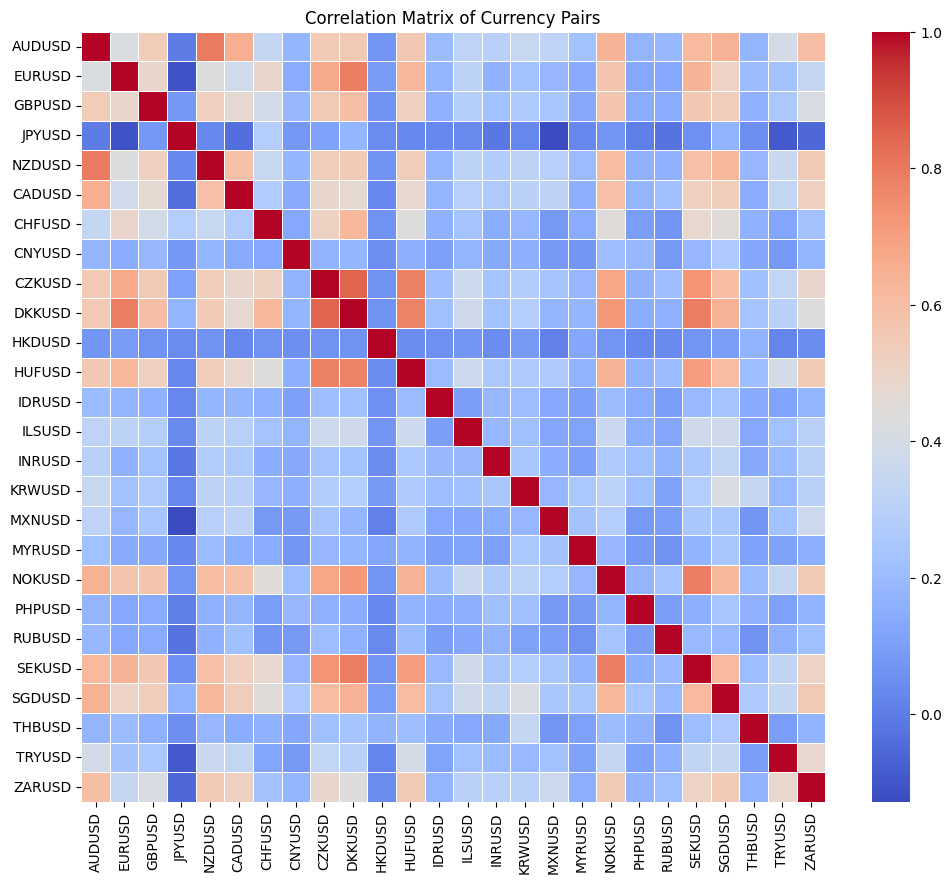

In [5]:
# Correlation analysis
log_returns_corr = log_returns_data.drop(columns=['Date']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(log_returns_corr, annot=False, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Matrix of Currency Pairs")
plt.show()

# Time Series Analysis

This involves examining the data for trends, seasonality, and other temporal patterns. Given the nature of financial data, such as currency log returns, this can be particularly insightful. We'll look at:

1. Trend Analysis: Identifying long-term movements in the data.
2. Seasonality Analysis: Checking for repeating patterns or cycles at regular intervals.
3. Volatility Clustering: Observing periods with high fluctuations and periods with relative calm.

## 1. Trend Analysis

We'll plot the cumulative sum of the log returns for each currency pair to observe any long-term trends in the data.

/var/folders/8c/54xdylrd32q5q2h0h83vhjm00000gn/T/ipykernel_32442/828088860.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_tab20b = cm.get_cmap('tab20b', 20)  # 20 distinct colors from tab20b
/var/folders/8c/54xdylrd32q5q2h0h83vhjm00000gn/T/ipykernel_32442/828088860.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_tab20c = cm.get_cmap('tab20c', 20)  # 20 distinct colors from tab20c (extending to match sizes for ease of use)
/var/folders/8c/54xdylrd32q5q2h0h83vhjm00000gn/T/ipykernel_32442/828088860.py:43: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor rele

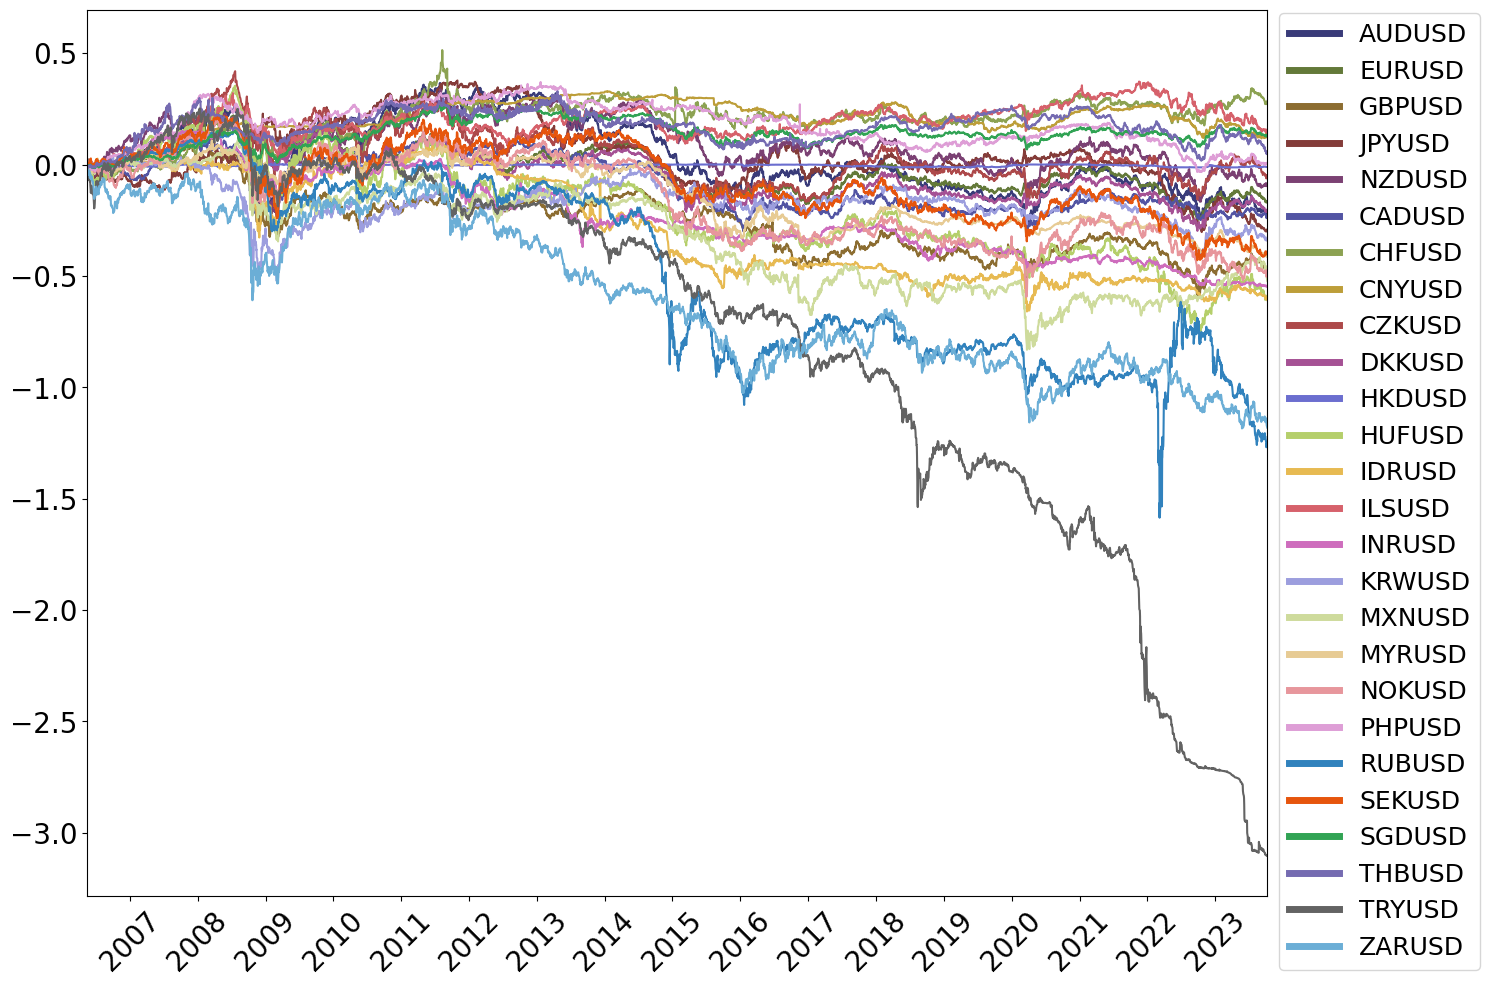

In [6]:
# Convert the 'Date' column to datetime and sort the data
log_returns_data['Date'] = pd.to_datetime(log_returns_data['Date'])

# Cumulative log returns
# sns.set_style('whitegrid')
log_returns_cumsum = log_returns_data.drop(columns=['Date']).cumsum()
plot_cumulative_log_returns(log_returns_data, log_returns_cumsum, None)

- Some currency pairs show a long-term downward trend, indicating a general decrease in their value against the USD over time.
- There are periods of increased volatility where the cumulative returns fluctuate more dramatically.
- The plot reveals that not all currency pairs behave similarly, with some showing more stability and others exhibiting more significant changes.

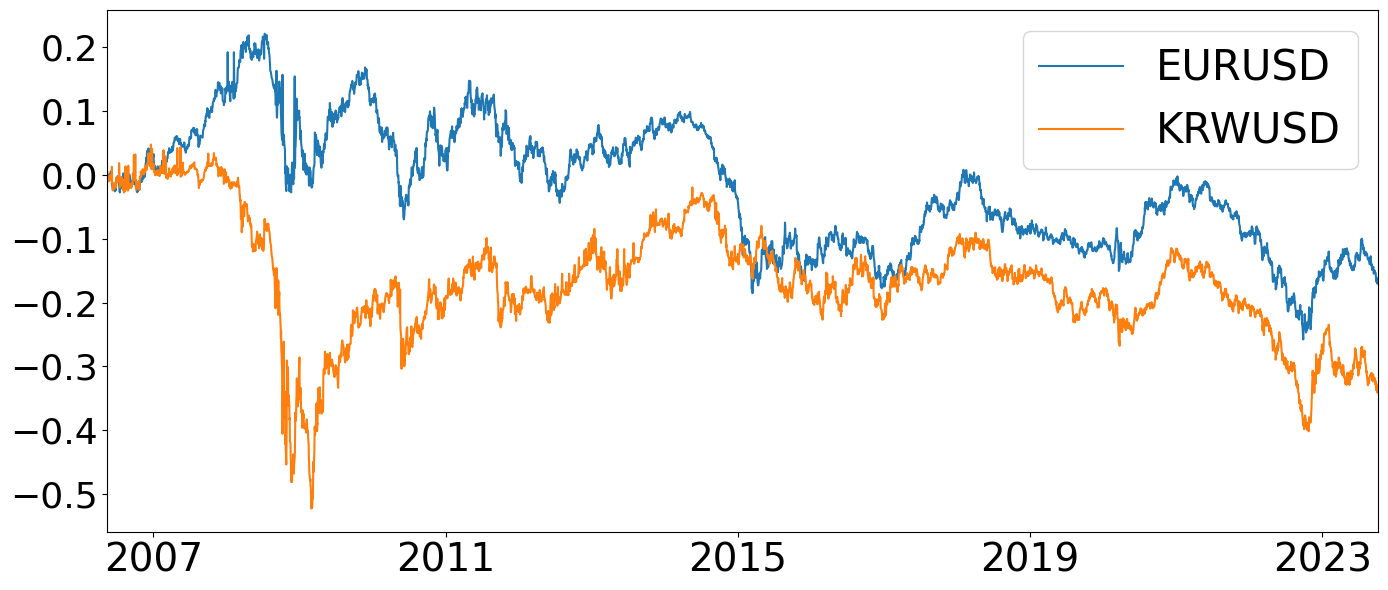

In [7]:
def select_cumulative_log_returns(data, cumsum_data, currencies=None):
    """Plots the cumulative log returns for given currencies."""
    plt.figure(figsize=(14, 6))
    if currencies is None:
        for column in cumsum_data.columns:
            plt.plot(data['Date'], cumsum_data[column], label=column)
    else:
        for currency in currencies:
            plt.plot(data['Date'], cumsum_data[currency], label=currency)

    # Setting the x-axis limits
    plt.xlim(pd.Timestamp('2006-05-17'), pd.Timestamp('2023-10-09'))

    # Generate tick labels within the specified range
    tick_labels = pd.date_range(start='2006-05-17', end='2023-10-09', freq='4YS')

    plt.xticks(ticks=tick_labels, labels=[label.strftime('%Y') for label in tick_labels], fontsize=28)
    plt.yticks(fontsize=26)
    plt.legend(fontsize=30)
    plt.tight_layout()
    # plt.savefig("Images/cum_sum_log_returns_EURDKK.svg", format="svg")
    plt.show()

# Selected currency pairs
selected_currencies = ['EURUSD', 'KRWUSD']
select_cumulative_log_returns(log_returns_data, log_returns_cumsum, selected_currencies)

/var/folders/8c/54xdylrd32q5q2h0h83vhjm00000gn/T/ipykernel_32442/828088860.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_tab20b = cm.get_cmap('tab20b', 20)  # 20 distinct colors from tab20b
/var/folders/8c/54xdylrd32q5q2h0h83vhjm00000gn/T/ipykernel_32442/828088860.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_tab20c = cm.get_cmap('tab20c', 20)  # 20 distinct colors from tab20c (extending to match sizes for ease of use)
/var/folders/8c/54xdylrd32q5q2h0h83vhjm00000gn/T/ipykernel_32442/828088860.py:43: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor rele

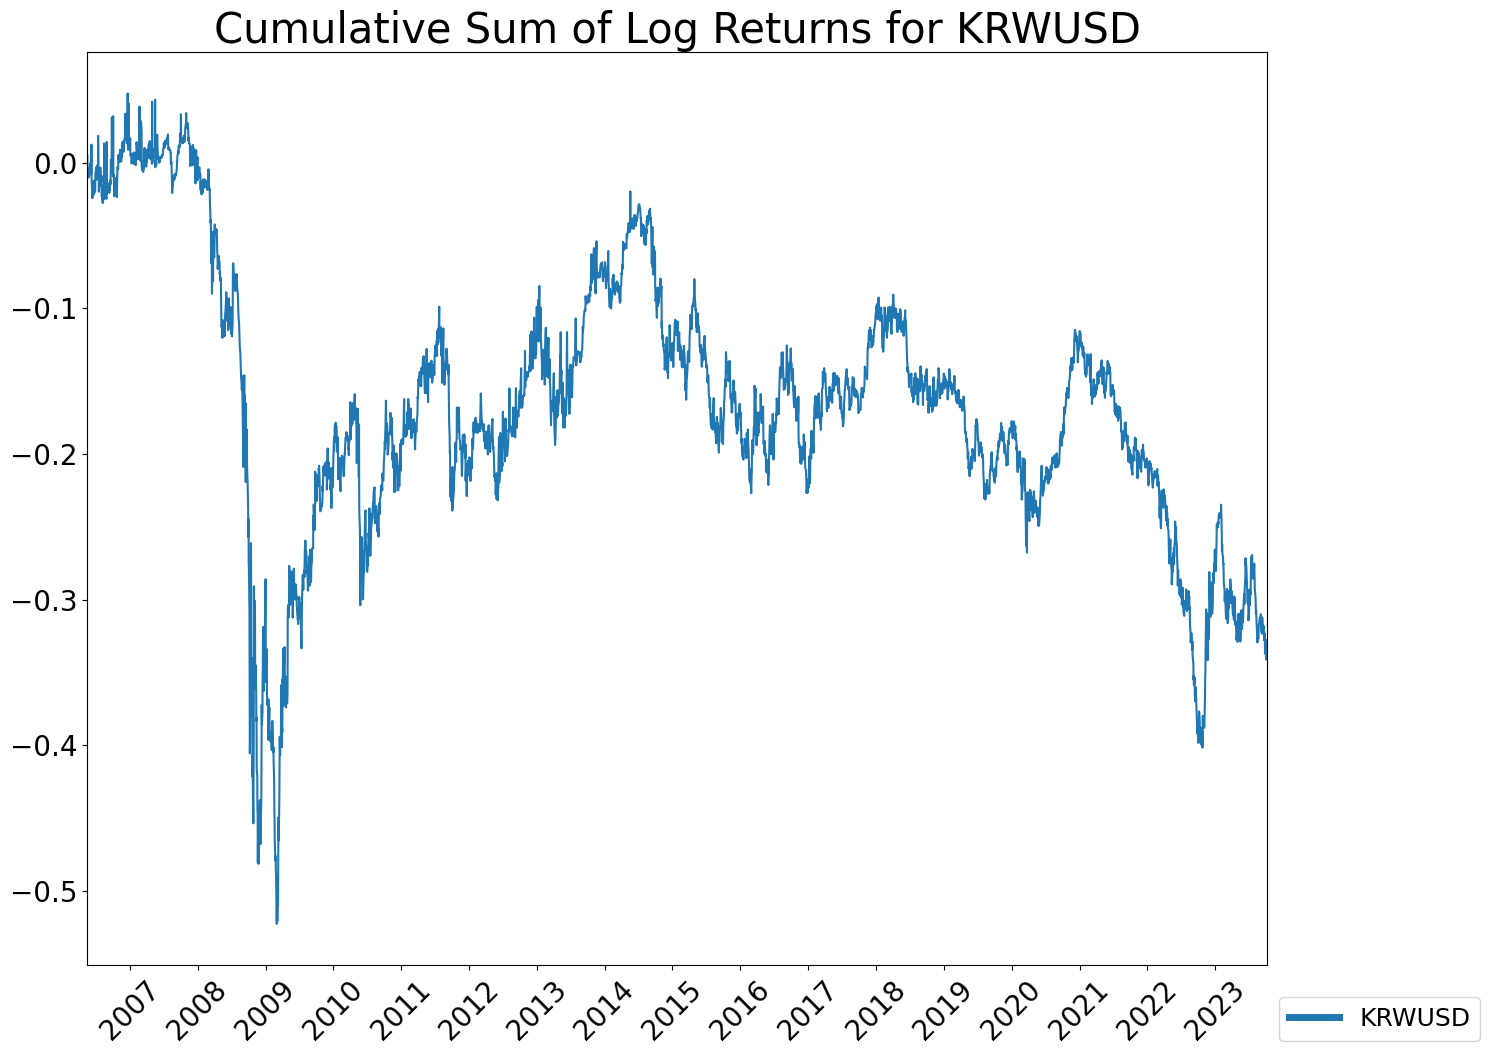

In [8]:
# Selected currency pairs
selected_currencies = ['KRWUSD']
plot_cumulative_log_returns(log_returns_data, log_returns_cumsum, 'Cumulative Sum of Log Returns for KRWUSD', selected_currencies)

## 2. Seasonality Analysis

I will use the seasonal_decompose function from the statsmodels library, which requires specifying the frequency of the seasonality. In financial data, seasonality can sometimes be observed on a quarterly basis (every 3 months), but it may not be present or may vary depending on the currency pair.

The number 252 is often used in financial time series analysis because it represents the approximate number of trading days in a year. This is based on the typical number of weekdays in a year, minus the number of public holidays that markets are closed. It's a standard figure used for estimating the number of days markets are active and is particularly useful for converting daily data to an annual scale.

This figure is relevant when performing analyses that require understanding the data on an annual basis, such as annual volatility or when looking for seasonal patterns that might occur on an annual cycle.

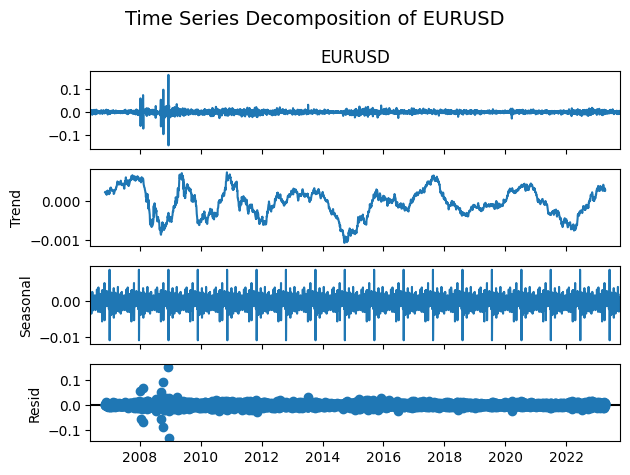

In [9]:
# Decompose and plot a currency pair
currency_pair = 'EURUSD'
decompose_and_plot(log_returns_data.set_index('Date'), currency_pair)

1. Observed: This is the actual log returns data that has been plotted.
2. Trend: This shows the long-term movement in the data, smoothing out short-term fluctuations.
3. Seasonal: This component captures the regular pattern within a year that repeats itself.
4. Residual: These are the irregularities in the data that cannot be explained by the trend or seasonal components.

For the EURUSD pair, 
- Trend Component: The trend line fluctuates around zero without a clear long-term upward or downward direction. This suggests that over the period under analysis, the 'EURUSD' currency pair does not exhibit a strong long-term trend in either direction.
- Seasonal Component: The seasonal plot shows some periodicity, but the fluctuations are very tight around the zero line, suggesting that any seasonality in the data is quite weak.
- Residuals: The residuals, which represent the noise or unexplained variation after the trend and seasonal components have been removed, show some periods of higher volatility. The clustering of extreme points (dots far from the zero line) indicates moments when the actual returns deviated significantly from the trend and seasonal patterns. These could correspond to unexpected market events or shocks.

## 3. Volatility Clustering

I will focus on examining the variability of the log returns for each currency pair. Volatility in financial markets is a measure of the degree of variation of a trading price series over time. It's commonly quantified using the standard deviation or variance of returns.

I already have standard deviation values from the descriptive statistics. However, for a more in-depth analysis, I can look at the rolling volatility over time. This involves calculating a moving standard deviation to see how volatility changes.

I'll plot the rolling volatility (using a 30-day window as an example). This will give us insights into how the volatility of these currency pairs has evolved over the dataset's time frame. 

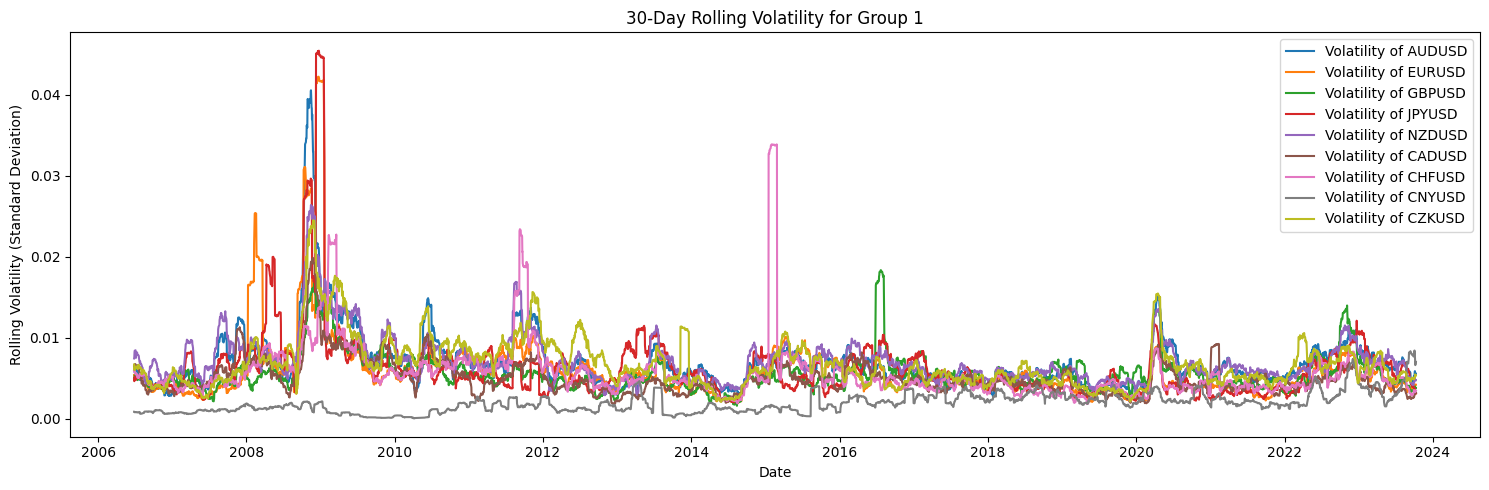

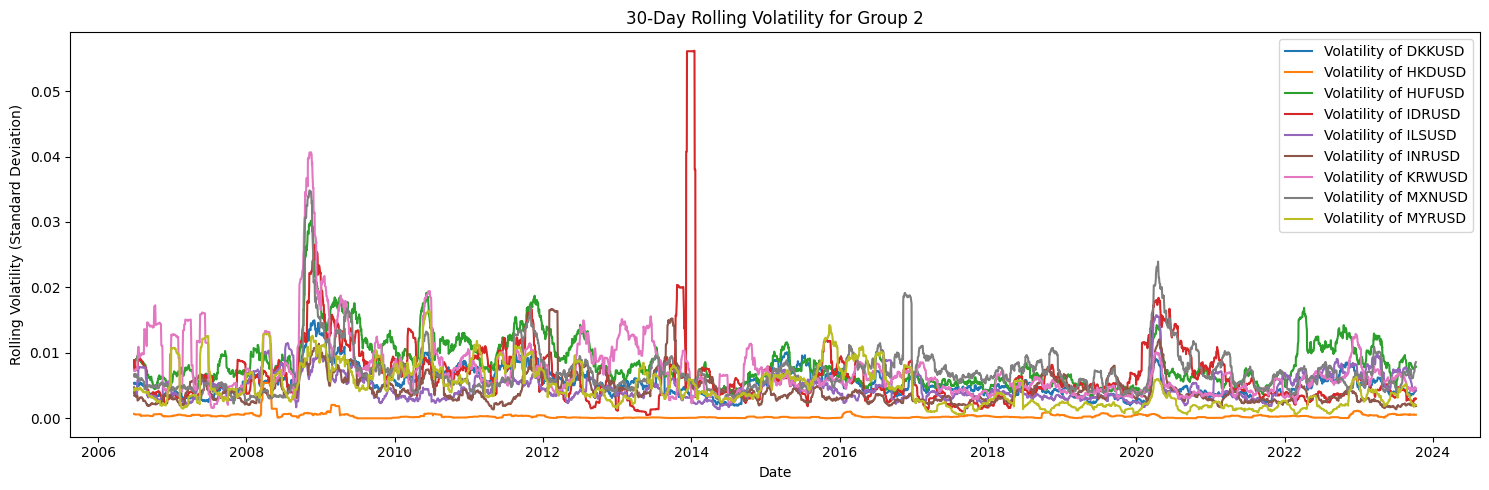

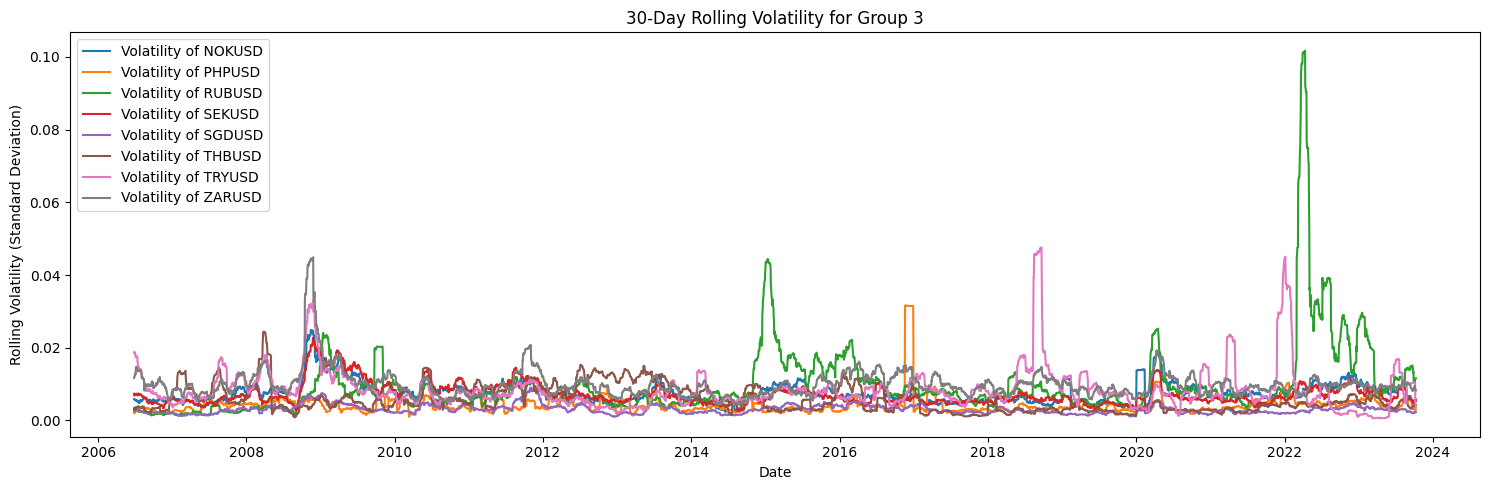

In [10]:
# Rolling volatility
rolling_window = 30
currencies = log_returns_data.columns[1:]  # Excluding 'Date'
group_1, group_2, group_3 = np.array_split(currencies, 3)
plot_rolling_volatility(log_returns_data, group_1, rolling_window, 1)
plot_rolling_volatility(log_returns_data, group_2, rolling_window, 2)
plot_rolling_volatility(log_returns_data, group_3, rolling_window, 3)

Most stable period: 2019-03-08 to 2020-03-06, Avg Volatility: 0.0040
Next most stable period: 2017-05-31 to 2018-05-29, Avg Volatility: 0.0044
Next most volatile period: 2011-05-06 to 2012-05-03, Avg Volatility: 0.0074
Most volatile period: 2008-09-17 to 2009-09-15, Avg Volatility: 0.0115


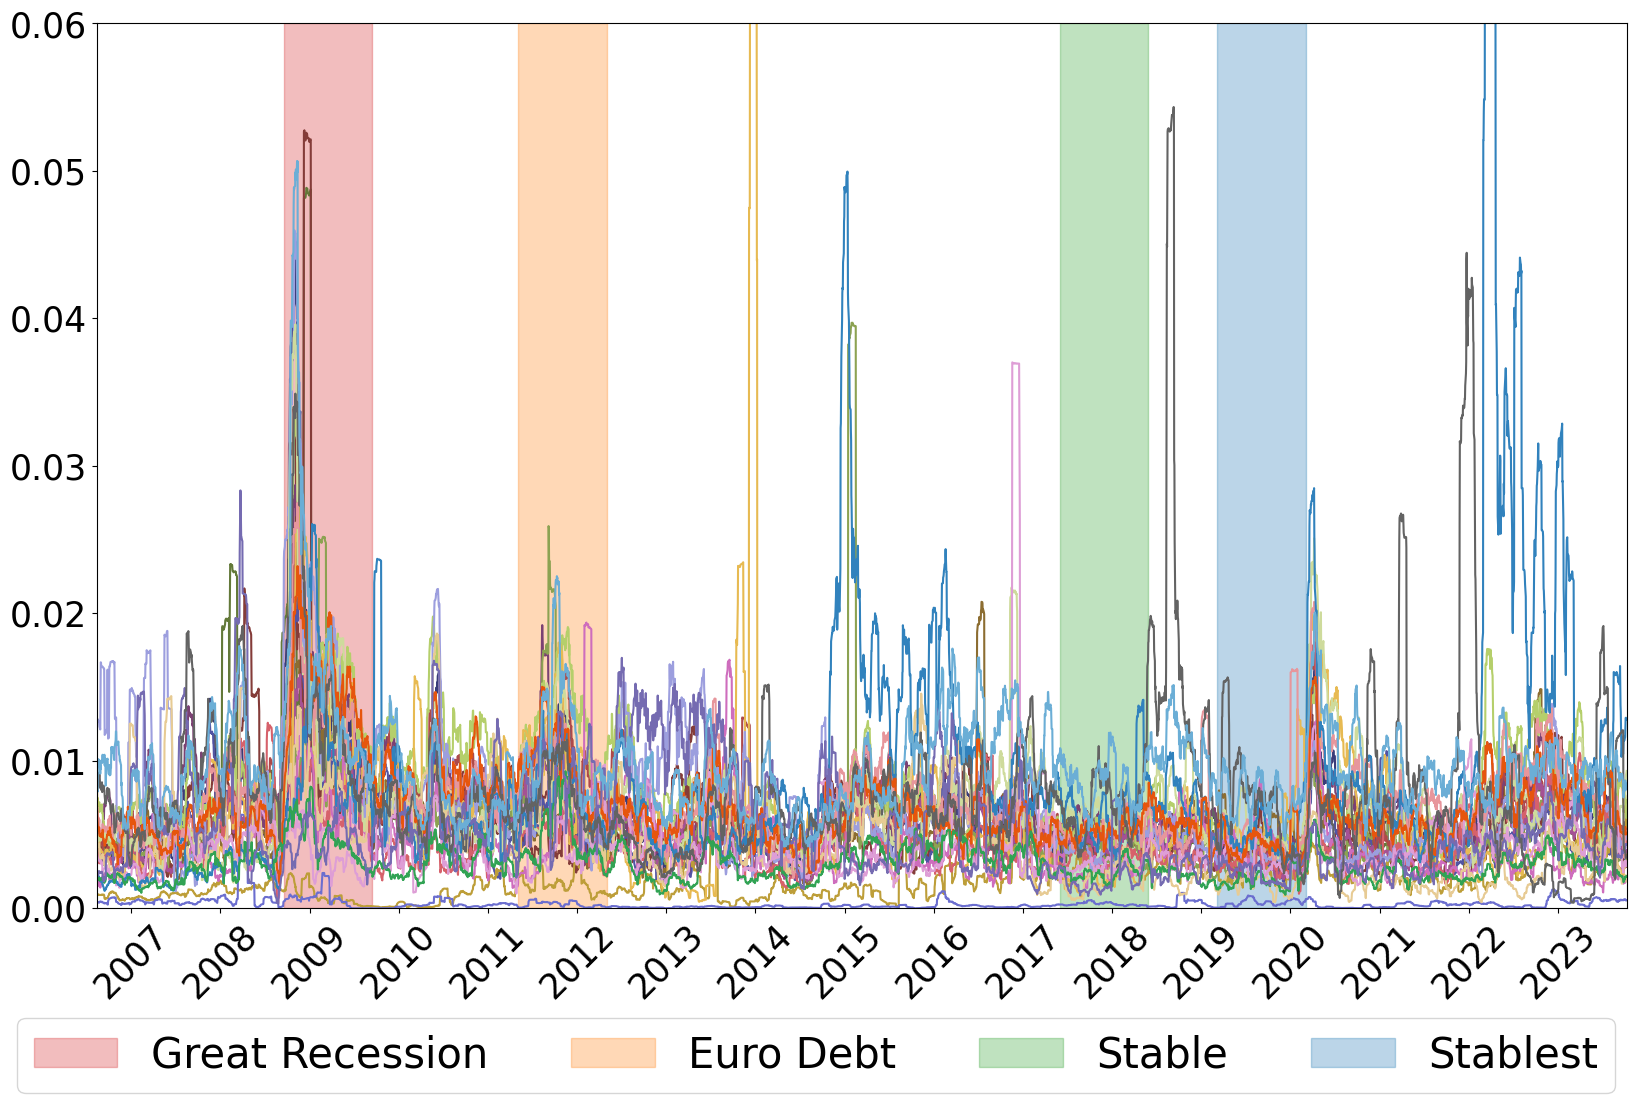

In [11]:
import matplotlib

def find_distinct_periods(data, years):
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
    elif not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("Data must have a 'Date' column or DatetimeIndex index.")
    
    quarter = 65 # quarter of a trading year
    N_quarters = 4 * years # how many quarters are we considering
    N_days = pd.Timedelta(days=365 * years) # how many 'actual' days are we considering
    rolling_volatility = data.rolling(window=quarter).std().mean(axis=1)

    combined_volatility = []
    dates = []

    for i in range(len(rolling_volatility) - quarter * N_quarters + 1):
        window_volatility = rolling_volatility.iloc[i:i + quarter * N_quarters].mean()
        combined_volatility.append(window_volatility)
        dates.append(rolling_volatility.index[i])
    
    combined_volatility_series = pd.Series(combined_volatility, index=dates)

    min_volatility_date = combined_volatility_series.idxmin()
    max_volatility_date = combined_volatility_series.idxmax()

    exclusion_range_min = set(pd.date_range(start=min_volatility_date - N_days,
                                            end=min_volatility_date + N_days))
    exclusion_range_max = set(pd.date_range(start=max_volatility_date - N_days,
                                            end=max_volatility_date + N_days))

    total_exclusion = exclusion_range_min.union(exclusion_range_max)

    combined_volatility_series_adj = combined_volatility_series[~combined_volatility_series.index.isin(total_exclusion)]

    next_min_volatility_date = combined_volatility_series_adj.idxmin()
    next_max_volatility_date = combined_volatility_series_adj.idxmax()

    # Adjusting the end dates calculation to ensure exactly 520 trading days
    min_end_date = data.index[data.index.get_loc(min_volatility_date) + N_quarters * quarter - 1]
    max_end_date = data.index[data.index.get_loc(max_volatility_date) + N_quarters * quarter - 1]
    next_min_end_date = data.index[data.index.get_loc(next_min_volatility_date) + N_quarters * quarter - 1]
    next_max_end_date = data.index[data.index.get_loc(next_max_volatility_date) + N_quarters * quarter - 1]

    print(f"Most stable period: {min_volatility_date.date()} to {min_end_date.date()}, Avg Volatility: {combined_volatility_series[min_volatility_date]:.4f}")
    print(f"Next most stable period: {next_min_volatility_date.date()} to {next_min_end_date.date()}, Avg Volatility: {combined_volatility_series_adj[next_min_volatility_date]:.4f}")
    print(f"Next most volatile period: {next_max_volatility_date.date()} to {next_max_end_date.date()}, Avg Volatility: {combined_volatility_series_adj[next_max_volatility_date]:.4f}")
    print(f"Most volatile period: {max_volatility_date.date()} to {max_end_date.date()}, Avg Volatility: {combined_volatility_series[max_volatility_date]:.4f}")

    return (
            (max_volatility_date, max_end_date),
            (next_max_volatility_date, next_max_end_date),
            (next_min_volatility_date, next_min_end_date),  
            (min_volatility_date, min_end_date)
    )

def plot_volatility(data, currencies_group, window_size):
    plt.figure(figsize=(16, 10))

    # Initialise colormaps
    cmap_tab20b = matplotlib.colormaps.get_cmap('tab20b')  # 20 distinct colors from tab20b
    cmap_tab20c = matplotlib.colormaps.get_cmap('tab20c')  # 20 distinct colors from tab20c (extending to match sizes for ease of use)

    # Select colors based on the specified pattern: every 4th color starting from the first, then the second, and so on
    indices_pattern = np.array([0, 4, 8, 12, 16, 1, 5, 9, 13, 17, 2, 6, 10, 14, 18, 3, 7, 11, 15, 19])
    colors = np.vstack([cmap_tab20b(indices_pattern / 19), cmap_tab20c(indices_pattern / 19)])

    for currency, color in zip(currencies_group, colors):
        rolling_volatility = data[currency].rolling(window=window_size).std()
        plt.plot(data['Date'], rolling_volatility, color=color)

    format_date_axis()
    plt.xlim(pd.Timestamp('2006-08-15'), pd.Timestamp('2023-10-09'))
    plt.ylim(0, 0.06)
    plt.tight_layout()

    # Find distinct periods and shade them
    distinct_periods = find_distinct_periods(data, years=1)
    colors = ['C3', 'C1', 'C2', 'C0']
    labels = ["Great Recession", "Euro Debt", "Stable", "Stablest"]

    for i, period in enumerate(distinct_periods):
        plt.axvspan(period[0], period[1], color=colors[i % len(colors)], alpha=0.3, label=labels[i])

    plt.legend(loc='upper center', bbox_to_anchor=(0.47, -0.1), fontsize=30, ncol=4)
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)

    plt.savefig("Images/volatility.svg", format="svg", bbox_inches='tight')
    plt.show()

log_returns_data = pd.read_csv("Results/log_returns_DKK.csv")

# Convert the 'Date' column to datetime and sort the data
log_returns_data['Date'] = pd.to_datetime(log_returns_data['Date'])
plot_volatility(log_returns_data, log_returns_data.columns[1:], 22)


In [12]:
data = pd.read_csv('Results/data_matrix_DKK.csv')

# Define the date ranges and labels
dates_labels = [
    ('2019-03-08', '2020-03-06', "most stable"),
    ('2017-05-31', '2018-05-29', "stable"),
    ('2011-05-06', '2012-05-03', "volatile"),
    ('2008-09-17', '2009-09-15', "most volatile")
]

# Initialise a dictionary to store the count of data points for each label
data_points_count = {}

# Loop through the date ranges and labels to filter the data and count the points
for start_date, end_date, label in dates_labels:
    # Filter data within the date range
    filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
    print(data[(data['Date'] == start_date)].to_numpy())
    print(data[(data['Date'] == end_date)].to_numpy())
    # Count the number of data points and add to the dictionary
    data_points_count[label] = len(filtered_data)

data_points_count

[['2019-03-08' -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1]]
[['2020-03-06' -1 1 1 1 1 -1 1 1 1 1 1 1 -1 -1 1 -1 -1 1 -1 1 -1 1 1 -1
  -1 -1]]
[['2017-05-31' 1 1 -1 1 1 1 1 1 1 1 1 1 1 1 -1 -1 1 -1 -1 -1 -1 1 1 1 1
  -1]]
[['2018-05-29' -1 -1 1 1 1 -1 -1 -1 -1 -1 -1 -1 1 -1 1 1 -1 -1 -1 1 -1 -1
  -1 -1 1 1]]
[['2011-05-06' -1 -1 -1 1 -1 -1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1 -1 -1
  -1 -1 -1 -1 -1 -1]]
[['2012-05-03' -1 -1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1 -1 1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1]]
[['2008-09-17' -1 1 1 1 1 1 1 1 1 1 -1 1 1 -1 1 1 -1 1 1 1 1 1 1 -1 -1 -1]]
[['2009-09-15' 1 1 -1 -1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


{'most stable': 260, 'stable': 260, 'volatile': 260, 'most volatile': 260}

Most stable period: 2014-04-23 to 2014-10-21, Avg Volatility: 0.00371
Next most stable period: 2019-09-02 to 2020-02-28, Avg Volatility: 0.00384
Third most stable period: 2019-03-01 to 2019-08-30, Avg Volatility: 0.00414
Third most volatile period: 2009-04-17 to 2009-10-15, Avg Volatility: 0.00848
Next most volatile period: 2011-08-05 to 2012-02-02, Avg Volatility: 0.00860
Most volatile period: 2008-10-15 to 2009-04-14, Avg Volatility: 0.01428


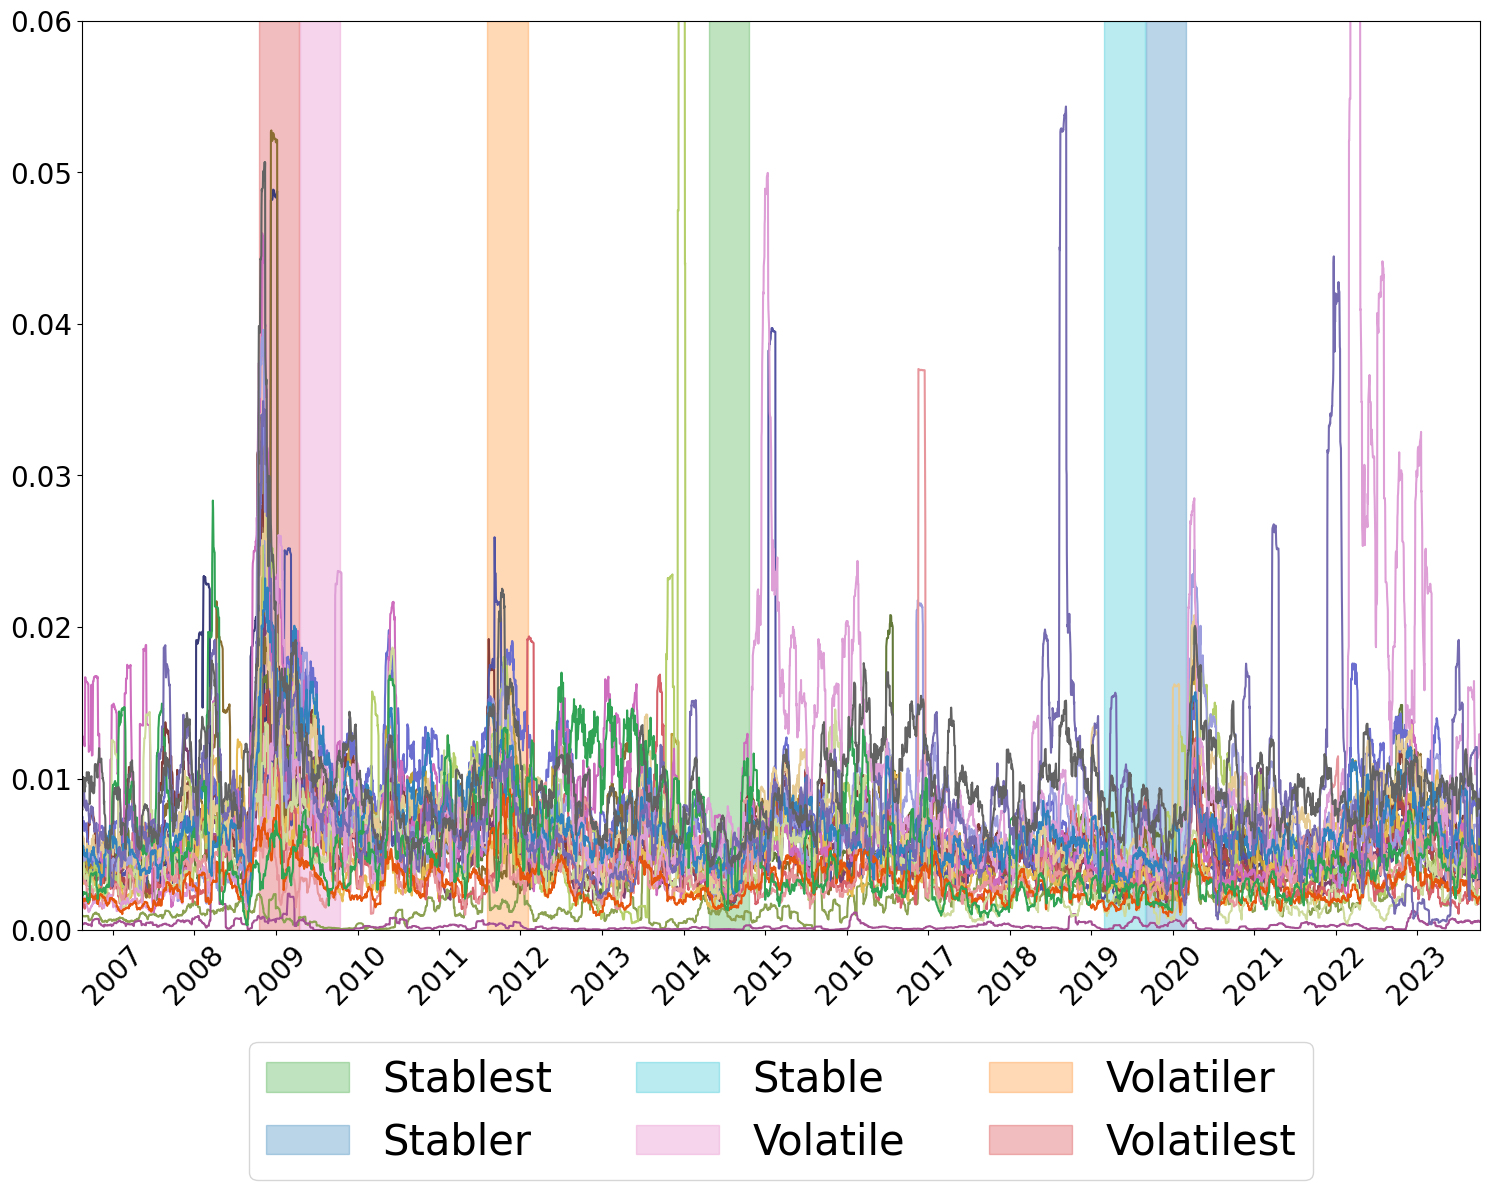

In [13]:
import matplotlib

def find_distinct_periods(data, years):
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
    elif not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("Data must have a 'Date' column or DatetimeIndex index.")
    
    quarter = 65 # quarter of a trading year
    N_quarters = 2 * years # how many quarters are we considering
    N_days = pd.Timedelta(days=183 * years) # how many 'actual' days are we considering
    rolling_volatility = data.rolling(window=quarter).std().mean(axis=1)

    combined_volatility = []
    dates = []

    for i in range(len(rolling_volatility) - quarter * N_quarters + 1):
        window_volatility = rolling_volatility.iloc[i:i + quarter * N_quarters].mean()
        combined_volatility.append(window_volatility)
        dates.append(rolling_volatility.index[i])
    
    combined_volatility_series = pd.Series(combined_volatility, index=dates)

    min_volatility_date = combined_volatility_series.idxmin()
    max_volatility_date = combined_volatility_series.idxmax()

    exclusion_range_min = set(pd.date_range(start=min_volatility_date - N_days,
                                            end=min_volatility_date + N_days))
    exclusion_range_max = set(pd.date_range(start=max_volatility_date - N_days,
                                            end=max_volatility_date + N_days))

    total_exclusion = exclusion_range_min.union(exclusion_range_max)

    combined_volatility_series_adj = combined_volatility_series[~combined_volatility_series.index.isin(total_exclusion)]

    next_min_volatility_date = combined_volatility_series_adj.idxmin()
    next_max_volatility_date = combined_volatility_series_adj.idxmax()

    next_exclusion_range = set(pd.date_range(start=next_min_volatility_date - N_days,
                                         end=next_min_volatility_date + N_days))
    next_exclusion_range_max = set(pd.date_range(start=next_max_volatility_date - N_days,
                                             end=next_max_volatility_date + N_days))
    total_exclusion = total_exclusion.union(next_exclusion_range)
    total_exclusion = total_exclusion.union(next_exclusion_range_max)

    combined_volatility_series_adj2 = combined_volatility_series[~combined_volatility_series.index.isin(total_exclusion)]

    # Identify the third set of most stable and volatile periods
    third_min_volatility_date = combined_volatility_series_adj2.idxmin()
    third_max_volatility_date = combined_volatility_series_adj2.idxmax()

    min_end_date = data.index[data.index.get_loc(min_volatility_date) + N_quarters * quarter - 1]
    max_end_date = data.index[data.index.get_loc(max_volatility_date) + N_quarters * quarter - 1]
    next_min_end_date = data.index[data.index.get_loc(next_min_volatility_date) + N_quarters * quarter - 1]
    next_max_end_date = data.index[data.index.get_loc(next_max_volatility_date) + N_quarters * quarter - 1]
    third_min_end_date = data.index[data.index.get_loc(third_min_volatility_date) + N_quarters * quarter - 1]
    third_max_end_date = data.index[data.index.get_loc(third_max_volatility_date) + N_quarters * quarter - 1]
    
    print(f"Most stable period: {min_volatility_date.date()} to {min_end_date.date()}, Avg Volatility: {combined_volatility_series[min_volatility_date]:.5f}")
    print(f"Next most stable period: {next_min_volatility_date.date()} to {next_min_end_date.date()}, Avg Volatility: {combined_volatility_series_adj[next_min_volatility_date]:.5f}")
    print(f"Third most stable period: {third_min_volatility_date.date()} to {third_min_end_date.date()}, Avg Volatility: {combined_volatility_series_adj2[third_min_volatility_date]:.5f}")
    print(f"Third most volatile period: {third_max_volatility_date.date()} to {third_max_end_date.date()}, Avg Volatility: {combined_volatility_series_adj2[third_max_volatility_date]:.5f}")
    print(f"Next most volatile period: {next_max_volatility_date.date()} to {next_max_end_date.date()}, Avg Volatility: {combined_volatility_series_adj[next_max_volatility_date]:.5f}")
    print(f"Most volatile period: {max_volatility_date.date()} to {max_end_date.date()}, Avg Volatility: {combined_volatility_series[max_volatility_date]:.5f}")

    return (
        (min_volatility_date, min_end_date), 
        (next_min_volatility_date, next_min_end_date), 
        (third_min_volatility_date, third_min_end_date),
        (third_max_volatility_date, third_max_end_date),
        (next_max_volatility_date, next_max_end_date),
        (max_volatility_date, max_end_date)
    )

def plot_volatility(data, currencies_group, window_size):
    plt.figure(figsize=(15, 10.3))

    # Initialise colormaps
    cmap_tab20b = matplotlib.colormaps.get_cmap('tab20b')  # 20 distinct colors from tab20b
    cmap_tab20c = matplotlib.colormaps.get_cmap('tab20c')  # 20 distinct colors from tab20c (extending to match sizes for ease of use)

    # Select colors based on the specified pattern
    indices_pattern = np.array([0, 4, 8, 12, 16, 1, 5, 9, 13, 17, 2, 6, 10, 14, 18, 3, 7, 11, 15, 19])
    colors = np.vstack([cmap_tab20b(indices_pattern / 19), cmap_tab20c(indices_pattern / 19)])

    for currency, color in zip(currencies_group, colors):
        rolling_volatility = data[currency].rolling(window=window_size).std()
        plt.plot(data.index, rolling_volatility, color=color)

    plt.yticks(fontsize=20)
    format_date_axis()
    plt.xlim(pd.Timestamp('2006-08-15'), pd.Timestamp('2023-10-09'))
    plt.ylim(0, 0.06)
    plt.tight_layout()

    # Find distinct periods and shade them
    distinct_periods = find_distinct_periods(data, years=1)
    colors = ['C2', 'C0', 'C9', 'C6', 'C1', 'C3']  # Add more colors for the additional periods
    labels = ["Stablest", "Stabler", "Stable", "Volatile", "Volatiler", "Volatilest"]

    for i, period in enumerate(distinct_periods):
        plt.axvspan(period[0], period[1], color=colors[i % len(colors)], alpha=0.3, label=labels[i])

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize=30, ncol=3)

    plt.show()

# Example usage, assuming log_returns_data is your DataFrame with the 'Date' column converted to datetime
plot_volatility(log_returns_data, log_returns_data.columns[1:], 22)


In [14]:
data = pd.read_csv('Results/data_matrix_DKK.csv')

dates_labels = [
    ('2014-04-23', '2014-10-21', "most stable"),
    ('2019-09-02', '2020-02-28', "next most stable"),
    ('2019-03-01', '2019-08-30', "third most stable"),
    ('2009-04-17', '2009-10-15', "third most volatile"),
    ('2011-08-05', '2012-02-02', "next most volatile"),
    ('2008-10-15', '2009-04-14', "most volatile")
]

# Initialise a dictionary to store the count of data points for each label
data_points_count = {}

# Loop through the date ranges and labels to filter the data and count the points
for start_date, end_date, label in dates_labels:
    # Filter data within the date range
    filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
    print(data[(data['Date'] == start_date)].to_numpy())
    print(data[(data['Date'] == end_date)].to_numpy())
    # Count the number of data points and add to the dictionary
    data_points_count[label] = len(filtered_data)

data_points_count

[['2014-04-23' 1 1 1 1 1 -1 1 -1 1 1 1 1 -1 1 -1 -1 -1 -1 1 1 -1 1 -1 -1
  -1 -1]]
[['2014-10-21' 1 1 1 1 1 -1 1 1 1 1 -1 -1 1 -1 1 1 1 1 -1 1 -1 1 1 1 1 1]]
[['2019-09-02' -1 -1 -1 1 -1 -1 -1 -1 -1 -1 1 -1 1 1 -1 -1 1 1 -1 -1 -1
  -1 -1 1 -1 1]]
[['2020-02-28' 1 1 -1 1 1 -1 1 1 1 1 -1 1 -1 -1 -1 1 -1 1 1 1 -1 1 1 1 -1
  -1]]
[['2019-03-01' -1 -1 -1 -1 -1 -1 1 -1 1 -1 -1 1 -1 -1 1 -1 -1 1 -1 -1 -1
  1 -1 -1 -1 -1]]
[['2019-08-30' -1 -1 -1 -1 -1 1 -1 1 -1 -1 -1 -1 1 -1 1 1 1 -1 -1 1 1 -1
  1 -1 -1 1]]
[['2009-04-17' 1 -1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1 1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1]]
[['2009-10-15' 1 1 1 -1 -1 -1 1 -1 1 1 1 1 1 1 -1 -1 -1 1 -1 -1 1 -1 1 -1
  -1 -1]]
[['2011-08-05' -1 -1 -1 -1 -1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 1 -1 -1
  -1 -1 -1 -1 -1 -1]]
[['2012-02-02' 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 -1 1 1 -1 1 1]]
[['2008-10-15' -1 -1 -1 1 -1 -1 1 -1 -1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 1 -1 -1]]
[['2009-04-14' -1 -1 1 1 -1 1 -1 1 -1 -1 1 1 1 -1 1 -1 -1 -

{'most stable': 130,
 'next most stable': 130,
 'third most stable': 130,
 'third most volatile': 130,
 'next most volatile': 130,
 'most volatile': 130}

# Distribution Analysis

I will focus on understanding how the log returns of each currency pair are distributed. I can conduct normality tests, such as the Shapiro-Wilk test, to statistically assess whether the data follow a normal distribution. Additionally, I can plot histograms and Q-Q (quantile-quantile) plots for a visual assessment of normality.

In [15]:
# Normality test
normality_test_results = {currency: shapiro(log_returns_data[currency]) for currency in log_returns_data.columns[1:]}
normality_test_df = pd.DataFrame.from_dict(normality_test_results, orient='index', columns=['Statistic', 'p-value'])
normality_test_df

Statistic       p-value
EURUSD   0.741488  0.000000e+00
GBPUSD   0.942946  1.031981e-38
JPYUSD   0.755167  0.000000e+00
NZDUSD   0.962265  7.657287e-33
CADUSD   0.958936  5.301617e-34
CHFUSD   0.789912  0.000000e+00
CNYUSD   0.843670  0.000000e+00
CZKUSD   0.955500  4.008947e-35
DKKUSD   0.973684  3.892474e-28
HKDUSD   0.410690  0.000000e+00
HUFUSD   0.959029  5.701028e-34
IDRUSD   0.692048  0.000000e+00
ILSUSD   0.947796  2.078686e-37
INRUSD   0.908393  0.000000e+00
KRWUSD   0.850606  0.000000e+00
MXNUSD   0.915691  9.809089e-45
MYRUSD   0.868302  0.000000e+00
NOKUSD   0.964686  6.003781e-32
PHPUSD   0.743534  0.000000e+00
RUBUSD   0.664033  0.000000e+00
SEKUSD   0.971069  2.455217e-29
SGDUSD   0.963053  1.478964e-32
THBUSD   0.839167  0.000000e+00
TRYUSD   0.813548  0.000000e+00
ZARUSD   0.948802  3.983125e-37

The Shapiro-Wilk test tests the null hypothesis that the data is normally distributed. A p-value less than the chosen alpha level (commonly 0.05) suggests that we reject the null hypothesis, indicating the data is not normally distributed.

Rejecting the null hypothesis in the context of a statistical test, like the Shapiro-Wilk test for normality, has specific implications based on the nature of the hypothesis being tested.

In statistical hypothesis testing, there are typically two hypotheses:

1. Null Hypothesis (H0): This is a statement of 'no effect' or 'no difference.' It's the hypothesis that the test aims to examine. In the case of the Shapiro-Wilk test, the null hypothesis is that the data follows a normal distribution.
2. Alternative Hypothesis (H1 or Ha): This is the hypothesis that there is an effect or a difference. In this case, the alternative hypothesis would be that the data does not follow a normal distribution.
When I perform a test like the Shapiro-Wilk test, I calculate a p-value, which is the probability of observing my data, or something more extreme, assuming the null hypothesis is true.

If this p-value is below a certain threshold (commonly 0.05), I reject the null hypothesis. This means that the evidence in my data is strong enough to conclude that the data does not follow a normal distribution.
If the p-value is above the threshold, I do not reject the null hypothesis. This doesn't necessarily prove the null hypothesis is true, but rather that there isn't enough evidence to conclude otherwise.
In the analysis I performed, since the p-values for the Shapiro-Wilk test were effectively zero (or very close to it) for all the currency pairs, I rejected the null hypothesis. This means I concluded that the log returns for these currency pairs do not follow a normal distribution, based on the data I analysed.

To supplement these statistical test results, I can also visually assess the distribution of these returns using histograms and Q-Q plots. 

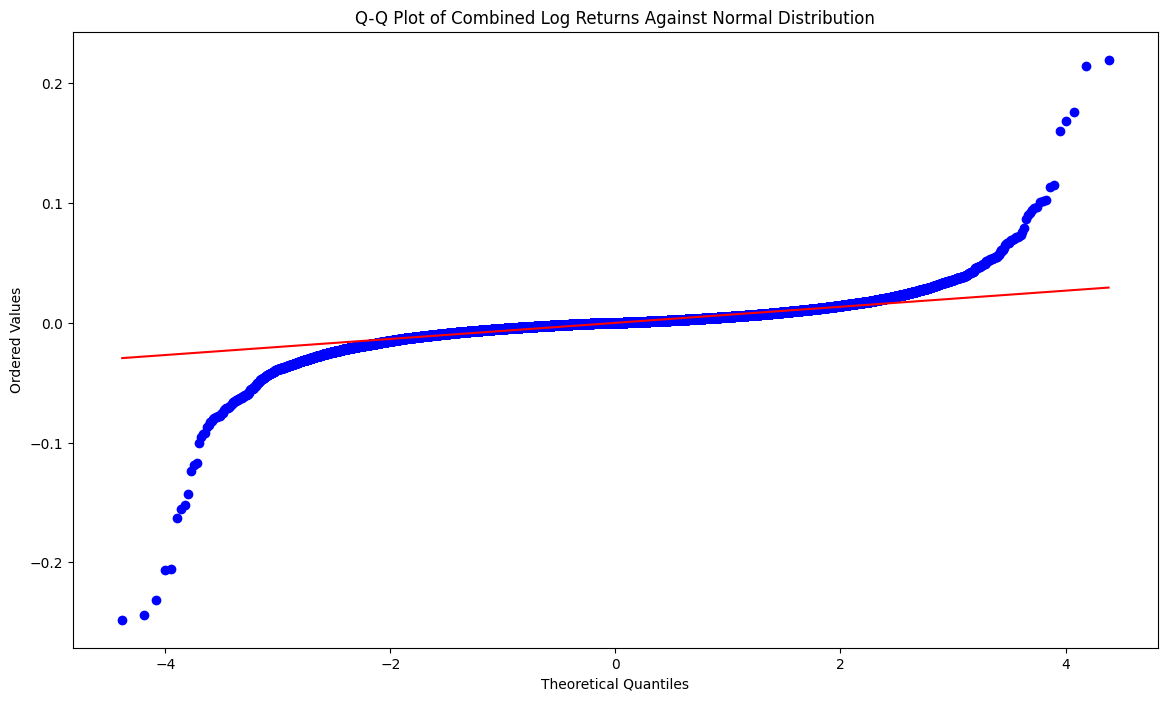

In [16]:
# Aggregated log returns
log_returns_data = pd.read_csv("Results/log_returns_DKK.csv")
all_log_returns = log_returns_data.drop(columns='Date').values.flatten()

# Q-Q plot
plt.figure(figsize=(14, 8))
stats.probplot(all_log_returns, dist="norm", plot=plt)
plt.title('Q-Q Plot of Combined Log Returns Against Normal Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()

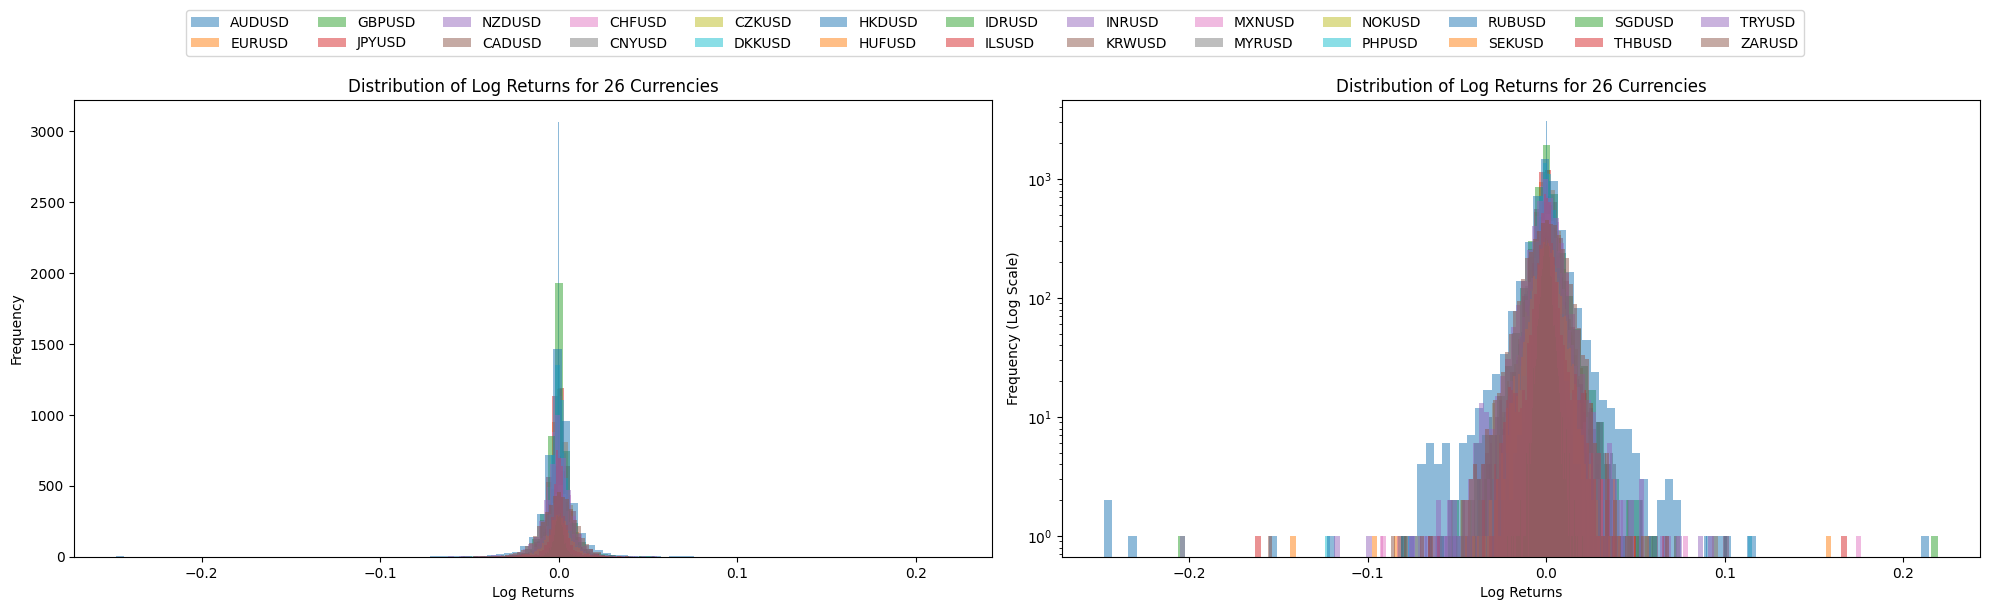

In [17]:
plot_histograms_side_by_side(log_returns_data, log_returns_data.columns[1:], bins=100)

In [18]:
# Calculate the ideal number of bins using the Freedman-Diaconis rule
IQR = np.percentile(all_log_returns, 75) - np.percentile(all_log_returns, 25)
bin_width = 2 * IQR * len(all_log_returns) ** (-1/3)
bins = int((max(all_log_returns) - min(all_log_returns)) / bin_width)
print(f"Ideal bin size: {bins}")

Ideal bin size: 1956


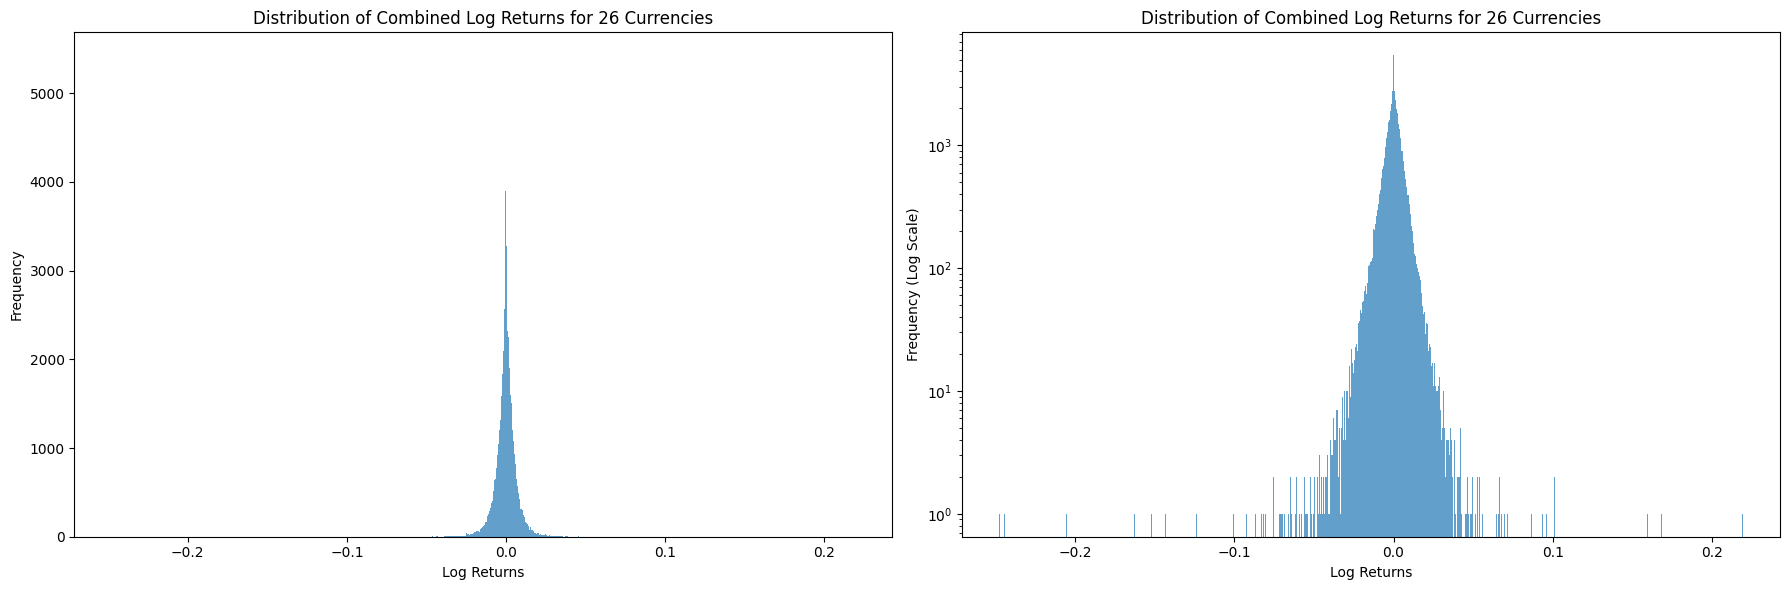

In [19]:
max_frequency = plot_combined_histogram_side_by_side(all_log_returns, bins=1956)

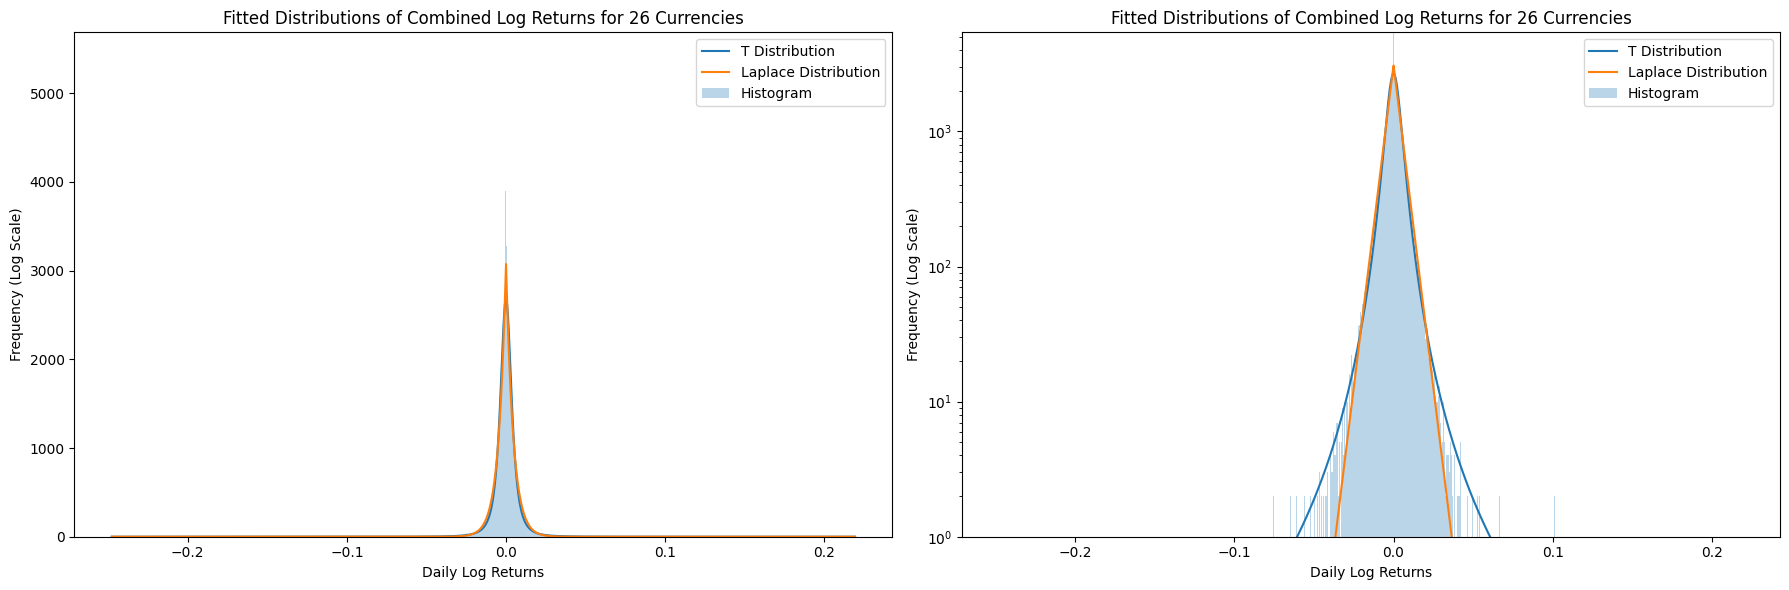

Distribution KS Statistic   P-Value                 Parameters
0            t       0.0226     1e-52  [2.36, 2.22e-05, 0.00378]
1      laplace       0.0188  9.88e-37       [-1.28e-06, 0.00455]

In [20]:
# Fitting distributions and compiling results
distributions = [t, laplace]
distribution_names = ["t", "laplace"]
fit_results_df = fit_and_plot_distributions_side_by_side(all_log_returns, distributions, distribution_names, bins=1956, max_frequency=max_frequency)
fit_results_df

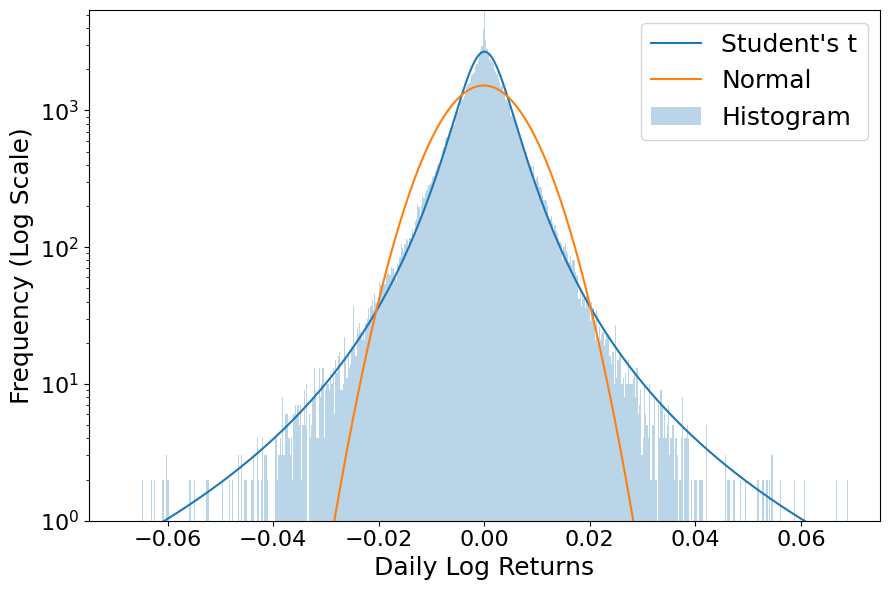

Distribution KS Statistic P-Value                 Parameters
0  Student's t       0.0226   1e-52  [2.36, 2.22e-05, 0.00378]
1       Normal        0.102       0        [-8.85e-05, 0.0074]

In [21]:
def fit_and_plot_distribution(data, bins, max_frequency):
    """Fits a distribution, compiles results, and plots a frequency histogram alongside the fitted distribution on a logarithmic scale."""
    fit_results = []

    # Define the distributions
    distributions = {
        'Student\'s t': stats.t,
        'Normal': stats.norm
    }

    # Generate the histogram data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Simplified calculation

    # Calculate the area under the histogram for scaling the PDF to frequencies
    area_under_histogram = np.sum(counts) * (bin_edges[1] - bin_edges[0])

    # Create a single subplot for the second plot only
    fig, axis = plt.subplots(figsize=(9, 6))

    # Configure the plot to use logarithmic scale and set limits
    axis.set_yscale('log')
    axis.set_ylim(1, max_frequency)
    axis.set_xlim(-0.075, 0.075)  # Set the x-axis limits

    # Plot the histogram
    axis.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]), alpha=0.3, label='Histogram')

    for name, dist in distributions.items():
        # Fit the distribution to the data
        params = dist.fit(data)
        # Scale the PDF by the area under the histogram
        scaled_pdf = dist.pdf(bin_centers, *params) * area_under_histogram
        axis.plot(bin_centers, scaled_pdf, label=f'{name.capitalize()}')

        # Perform the KS test
        ks_statistic, p_value = stats.kstest(data, dist.cdf, args=params)
        fit_results.append({
            "Distribution": name,
            "KS Statistic": "{:.3g}".format(ks_statistic),
            "P-Value": "{:.3g}".format(p_value),
            "Parameters": [f"{param:.3g}" for param in params]
        })

    # Set titles and labels
    axis.set_xlabel('Daily Log Returns', fontsize = 18)
    axis.set_ylabel('Frequency (Log Scale)', fontsize = 18)
    axis.legend(fontsize = 18)

    plt.yticks(fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.tight_layout()
    plt.savefig("Images/heavy-tailed.svg", format="svg", bbox_inches='tight')
    plt.show()

    return pd.DataFrame(fit_results)

# Fitting distributions and compiling results
fit_results_df = fit_and_plot_distribution(all_log_returns, bins=1956, max_frequency=max_frequency)
fit_results_df

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# List of distributions to potentially exclude because they are for positive values only
distributions_to_exclude = [
    'expon', 'gamma', 'lognorm', 'beta', 'chi2', 'nakagami', 'pareto',
    'tukeylambda', 'studentized_range', 'loglaplace', 'gausshyper', 'erlang', 'burr12'
]

# Getting a list of all continuous distributions available in scipy.stats
all_distributions = [dist for dist in dir(stats) if isinstance(getattr(stats, dist), stats.rv_continuous)]

# Filter out distributions not suitable for data with negative values
suitable_distributions = [dist for dist in all_distributions if dist not in distributions_to_exclude]

# Function to fit distribution and perform Kolmogorov-Smirnov test
def fit_distribution(data, distribution_name):
    dist = getattr(stats, distribution_name)
    try:
        params = dist.fit(data)
        ks_stat, ks_p_value = stats.kstest(data, distribution_name, args=params)
        return distribution_name, ks_stat, ks_p_value, 'Success'
    except Exception as e:  # Catching all exceptions can help avoid unexpected interruptions
        return distribution_name, np.nan, np.nan, f'Failed: {e}'

# Aggregated log returns
log_returns_data = pd.read_csv("Results/log_returns_DKK.csv")
all_log_returns = log_returns_data.drop(columns='Date').values.flatten()

fit_results = [fit_distribution(all_log_returns , dist) for dist in suitable_distributions]

# Sort results by p-value, descending (better fits first)
fit_results_sorted = sorted(fit_results, key=lambda x: x[2], reverse=True)

print(fit_results_sorted[:10])  # Show top 10 fits

# Currency Interaction Strengths Geographical Distances

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load J matrix from CSV
J_matrix_df = pd.read_csv('Results/J.csv')
J_matrix = J_matrix_df.to_numpy()

# Extract upper triangular part, excluding the diagonal
J_upper_triangular = np.triu(J_matrix, k=1)

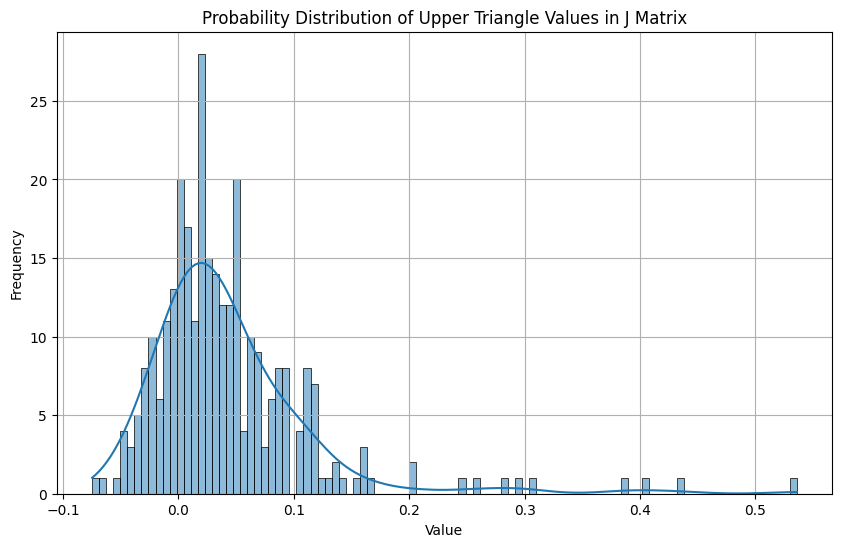

In [24]:
# Extracting the upper triangle of the matrix, excluding the diagonal
upper_triangle_values = J_matrix_df.where(np.triu(np.ones(J_matrix_df.shape), k=1).astype(bool)).stack()

# Plotting the histogram for the upper triangle values
plt.figure(figsize=(10, 6))
sns.histplot(upper_triangle_values, bins=100, kde=True)
plt.title('Probability Distribution of Upper Triangle Values in J Matrix')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [25]:
currency_to_capital = {
    'AUD': ('Canberra', -35.28, 149.13),   # Australia
    'EUR': ('Brussels', 50.85, 4.35),      # Eurozone (using Brussels, Belgium)
    'GBP': ('London', 51.51, -0.13),       # United Kingdom
    'JPY': ('Tokyo', 35.68, 139.76),       # Japan
    'NZD': ('Wellington', -41.29, 174.78), # New Zealand
    'CAD': ('Ottawa', 45.42, -75.69),      # Canada
    'CHF': ('Bern', 46.95, 7.45),          # Switzerland
    'CNY': ('Beijing', 39.90, 116.41),     # China
    'CZK': ('Prague', 50.08, 14.42),       # Czech Republic
#    'DKK': ('Copenhagen', 55.68, 12.57),   # Denmark
    'HKD': ('Hong Kong', 22.32, 114.17),   # Hong Kong
    'HUF': ('Budapest', 47.50, 19.04),     # Hungary
    'IDR': ('Jakarta', -6.21, 106.85),     # Indonesia
    'ILS': ('Jerusalem', 31.77, 35.22),    # Israel
    'INR': ('New Delhi', 28.61, 77.20),    # India
    'KRW': ('Seoul', 37.57, 126.98),       # South Korea
    'MXN': ('Mexico City', 19.43, -99.13), # Mexico
    'MYR': ('Kuala Lumpur', 3.14, 101.69), # Malaysia
    'NOK': ('Oslo', 59.91, 10.75),         # Norway
    'PHP': ('Manila', 14.60, 120.98),      # Philippines
    'RUB': ('Moscow', 55.76, 37.62),       # Russia
    'SEK': ('Stockholm', 59.33, 18.07),    # Sweden
    'SGD': ('Singapore', 1.35, 103.82),    # Singapore
    'THB': ('Bangkok', 13.76, 100.50),     # Thailand
    'TRY': ('Ankara', 39.93, 32.85),       # Turkey
    'ZAR': ('Pretoria', -25.75, 28.19)     # South Africa
}

In [26]:
from math import radians, cos, sin, asin, sqrt

def haversine(coord1, coord2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = map(radians, coord1)
    lat2, lon2 = map(radians, coord2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Example usage
distance_km = haversine(currency_to_capital['AUD'][1:], currency_to_capital['GBP'][1:])
print(f"Distance between Canberra and London: {distance_km} km")

Distance between Canberra and London: 16981.465653360876 km


In [27]:
from scipy.stats import pearsonr

def get_currency_code(currency_pair):
    """Extract currency codes from the currency pair, excluding 'USD'."""
    if currency_pair.startswith("USD"):
        return currency_pair[3:]
    else:
        return currency_pair[:3]

# Then, update the correlation analysis loop
distances = []
J_values = []

for i in range(J_upper_triangular.shape[0]):
    for j in range(i + 1, J_upper_triangular.shape[1]):
        if J_upper_triangular[i, j] != 0:
            # Extract currency codes
            currency1, currency2 = get_currency_code(J_matrix_df.columns[i]), get_currency_code(J_matrix_df.columns[j])

            # Skip if 'USD' is part of the pair
            if currency1 == 'USD' or currency2 == 'USD':
                continue

            # Calculate geographical distance
            coord1, coord2 = currency_to_capital[currency1][1:], currency_to_capital[currency2][1:]
            distance = haversine(coord1, coord2)
            distances.append(distance)

            # Store the corresponding J value
            J_values.append(J_upper_triangular[i, j])

# Convert lists to NumPy arrays for correlation calculation
distances = np.array(distances)
J_values = np.array(J_values)

# Compute Pearson correlation coefficient
correlation, p_value = pearsonr(distances, J_values)

print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Correlation coefficient: -0.28652221275747514
P-value: 4.459292768285713e-07


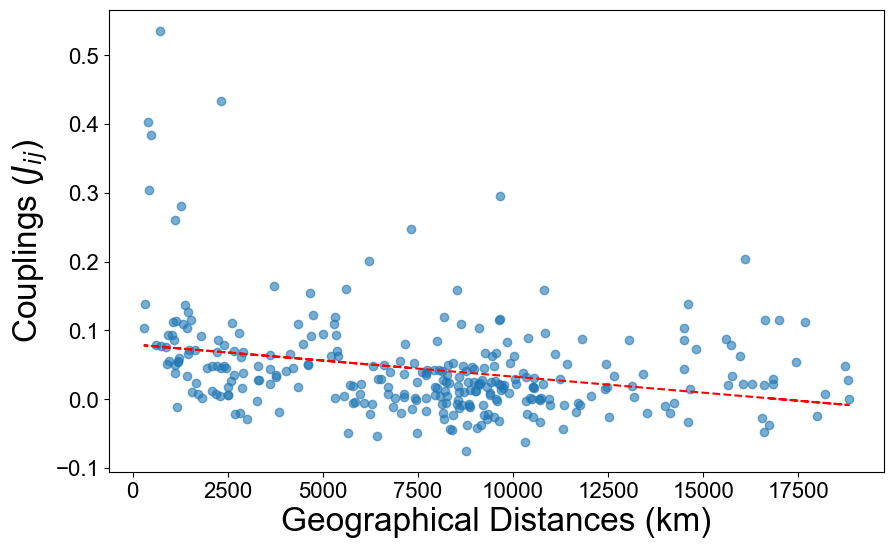

In [28]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(distances, J_values, alpha=0.6)

# Adding a title and labels
# plt.title('Currency Interaction Strengths and Correlation between Geographical Distances')
plt.xlabel('Geographical Distances (km)', fontsize=24)
plt.ylabel(r'Couplings ($\mathit{J}_{ij}$)', fontsize=24)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)

# Optional: Fit and plot a regression line
z = np.polyfit(distances, J_values, 1)
p = np.poly1d(z)
plt.plot(distances, p(distances), "r--")

# Show the plot
sns.set_style('whitegrid')
sns.set_context("paper")
plt.savefig("Images/J_geographical.svg", format="svg", bbox_inches='tight')
plt.show()

In [29]:
# 'J_values' is the array with J interaction strengths and 'distances' is the array with corresponding geographical distances
max_J_value = np.max(J_values)
max_J_index = np.argmax(J_values)

# Assuming 'J_matrix_df' is the DataFrame of the J matrix with proper column labels
currency_pairs = [(J_matrix_df.columns[i], J_matrix_df.columns[j])
                  for i in range(J_upper_triangular.shape[0])
                  for j in range(i + 1, J_upper_triangular.shape[1])
                  if J_upper_triangular[i, j] != 0]

# The currency pair corresponding to the max J value
outlier_pair = currency_pairs[max_J_index]
print(f"The currency pair with the interaction strength above 1.4 is: {outlier_pair}")

The currency pair with the interaction strength above 1.4 is: ('EURUSD', 'CZKUSD')


# Fit of Various Distributions to J

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# List of distributions to potentially exclude because they are for positive values only
distributions_to_exclude = [
    'expon', 'gamma', 'lognorm', 'beta', 'chi2', 'nakagami', 'pareto',
    'tukeylambda', 'studentized_range', 'loglaplace', 'gausshyper', 'erlang', 'burr12'
]

# Getting a list of all continuous distributions available in scipy.stats
all_distributions = [dist for dist in dir(stats) if isinstance(getattr(stats, dist), stats.rv_continuous)]

# Filter out distributions not suitable for data with negative values
suitable_distributions = [dist for dist in all_distributions if dist not in distributions_to_exclude]

# Function to fit distribution and perform Kolmogorov-Smirnov test
def fit_distribution(data, distribution_name):
    dist = getattr(stats, distribution_name)
    try:
        params = dist.fit(data)
        ks_stat, ks_p_value = stats.kstest(data, distribution_name, args=params)
        return distribution_name, ks_stat, ks_p_value, 'Success'
    except Exception as e:  # Catching all exceptions can help avoid unexpected interruptions
        return distribution_name, np.nan, np.nan, f'Failed: {e}'

# File paths for the datasets with labels
dates_labels = [
    ('2019-03-08', '2020-03-06', "Stablest"),
    ('2017-05-31', '2018-05-29', "Stable"),
    ('2011-05-06', '2012-05-03', "Euro Dept Crisis"),
    ('2008-09-17', '2009-09-15', "Great Recession")
]

# Execute the simulation and collect data for each dataset
data_matrix = pd.read_csv('Results/data_matrix.csv')
from Utility.IsingOptimiserReturn import IsingOptimiser
for start_date, end_date, label in dates_labels:
    ising_optimiser = IsingOptimiser(data_matrix, start_date, end_date)
    _, J_matrix, _ = ising_optimiser.train(100)

    J = J_matrix[np.triu_indices_from(J_matrix, k=1)]
    fit_results = [fit_distribution(J, dist) for dist in suitable_distributions]

    # Sort results by p-value, descending (better fits first)
    fit_results_sorted = sorted(fit_results, key=lambda x: x[2], reverse=True)

    print(fit_results_sorted[:10])  # Show top 10 fits

Optimisation completed with averaged results after 10 successes with 10 attempts.



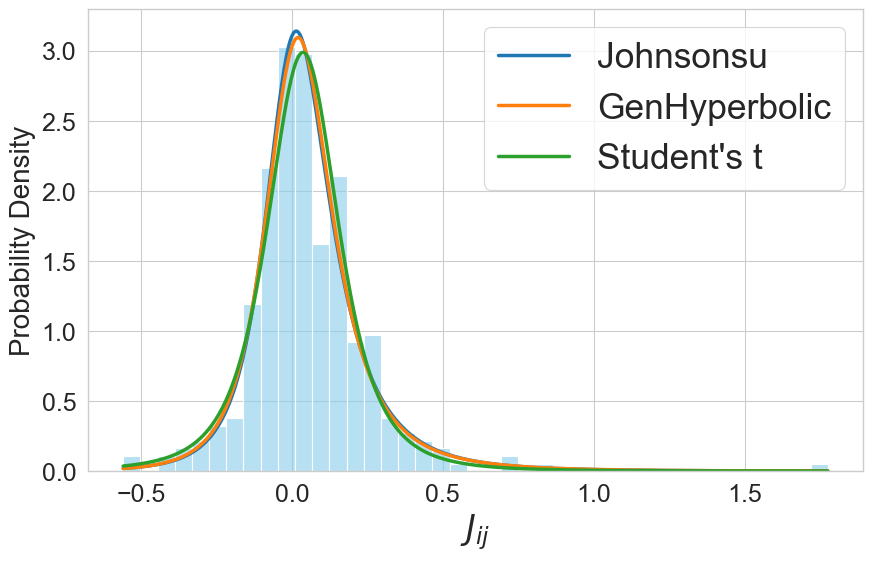

Ideal bin size: 40
Johnsonsu: KS Statistic = 0.03473081077760809, p-value = 0.8147375345663244
Student's t: KS Statistic = 0.04357956469399321, p-value = 0.5528029741395717
Laplace: KS Statistic = 0.06139782575297689, p-value = 0.16545570586363523
Burr: KS Statistic = 0.04598533629993384, p-value = 0.48358834015422114
GenHyperbolic: KS Statistic = 0.03525628801448144, p-value = 0.8004083729654947
Fisk: KS Statistic = 0.04558839242149182, p-value = 0.4947355284895756
ExponNorm: KS Statistic = 0.06437559198718631, p-value = 0.1294506365619108
FoldCauchy: KS Statistic = 0.05842961638931976, p-value = 0.20882981128597722
Optimisation completed with averaged results after 10 successes with 10 attempts.



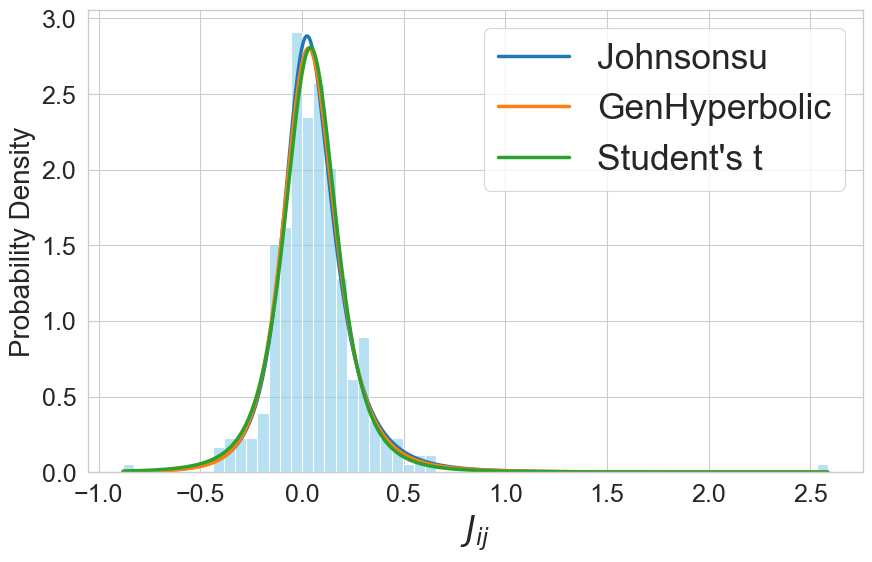

Ideal bin size: 62
Johnsonsu: KS Statistic = 0.029206059818888463, p-value = 0.9367223405883371
Student's t: KS Statistic = 0.03301642849555746, p-value = 0.858756324925368
Laplace: KS Statistic = 0.047148367640550914, p-value = 0.45164451219835133
Burr: KS Statistic = 0.03563141528208208, p-value = 0.7899767954595318
GenHyperbolic: KS Statistic = 0.03036506750166207, p-value = 0.9163452064355118
Fisk: KS Statistic = 0.0351090628360764, p-value = 0.8044576390734086
ExponNorm: KS Statistic = 0.05800062910414508, p-value = 0.21576332219170768
FoldCauchy: KS Statistic = 0.0639630587127249, p-value = 0.1340214009380678
Optimisation completed with averaged results after 10 successes with 10 attempts.



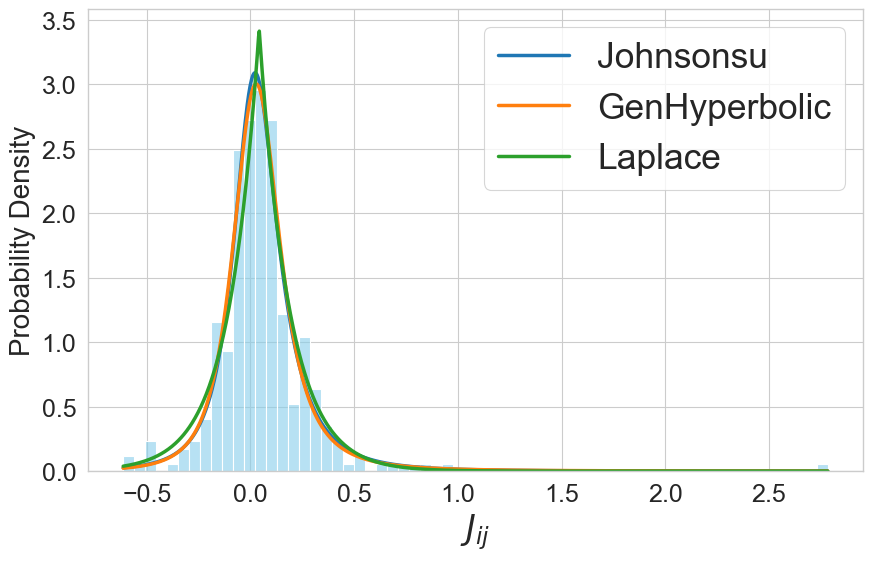

Ideal bin size: 63
Johnsonsu: KS Statistic = 0.02714631240076737, p-value = 0.9650667431671848
Student's t: KS Statistic = 0.04639271037508519, p-value = 0.4722745664876955
Laplace: KS Statistic = 0.040602639768298865, p-value = 0.6423489751170031
Burr: KS Statistic = 0.057414431868598154, p-value = 0.22551975417949155
GenHyperbolic: KS Statistic = 0.03173223777519174, p-value = 0.8884328167765879
Fisk: KS Statistic = 0.05778229456664696, p-value = 0.2193589220772708
FoldCauchy: KS Statistic = 0.05670634088807858, p-value = 0.23774542664305454
Optimisation completed with averaged results after 10 successes with 10 attempts.



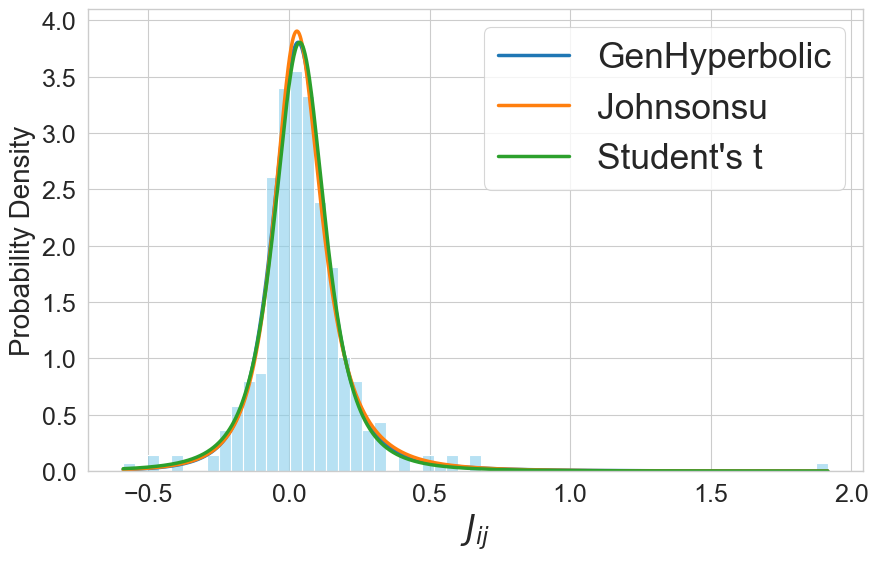

Ideal bin size: 58
Johnsonsu: KS Statistic = 0.03152967796254069, p-value = 0.8928192604532023
Student's t: KS Statistic = 0.03544707290651802, p-value = 0.7951229740888262
Laplace: KS Statistic = 0.050452870665643496, p-value = 0.36745557024055786
Burr: KS Statistic = 0.05980284966661112, p-value = 0.18778236126442782
GenHyperbolic: KS Statistic = 0.030384617056036844, p-value = 0.915974939732399
Fisk: KS Statistic = 0.056866074611344936, p-value = 0.23494504866225152
FoldCauchy: KS Statistic = 0.060606485437073365, p-value = 0.1762550896733437


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import johnsonsu, maxwell, t, laplace, norm, genextreme, \
                        burr, genhyperbolic, fisk, exponnorm, alpha, \
                        foldcauchy
import os
from bokeh.palettes import Pastel1 as palette

def fit_and_plot_distributions(key, parameters, label, exclude_negative=False):
    if key == 'J':
        # Extract upper triangular part, excluding the diagonal
        parameter = parameters[np.triu_indices_from(parameters, k=1)]
    else:
        parameter = parameters

    # Define the distributions
    distributions = {
        'Johnsonsu': johnsonsu,
        'Maxwell': maxwell,
        'Student\'s t': t,
        'Laplace': laplace,
        'Normal': norm,
        'GEV': genextreme,
        'Burr': burr,
        'GenHyperbolic': genhyperbolic,
        'Fisk': fisk,
        'ExponNorm': exponnorm,
        'Alpha': alpha,
        'FoldCauchy': foldcauchy
    }

    # Distributions that require only positive values
    positive_only_dists = ['Log-normal', 'Pareto', 'Weibull', 'Gamma']

    # Fit the distributions and calculate the KS statistics and p-values
    ks_results = {}
    distributions_to_fit = {}
    sortable_list = []

    for name, dist in distributions.items():
        if exclude_negative and name in positive_only_dists:
            continue  # Skip distributions that require only positive data

        data_to_fit = parameter if name not in positive_only_dists else parameter[parameter > 0]
        params = dist.fit(data_to_fit)
        ks_stat, ks_pval = kstest(data_to_fit, dist.cdf, params)
        
        if ks_pval > 0.05:
            ks_results[name] = (ks_stat, ks_pval)
            sortable_list.append((ks_pval, name, dist))

    # Sort the list in descending order of ks_pval
    sortable_list.sort(reverse=True, key=lambda x: x[0])

    # Create the ordered dictionary from the sorted list
    for _, name, dist in sortable_list:
        distributions_to_fit[name] = dist

    # Plot the results
    # plot_ks_results(ks_results, csv_file)
    plot_distributions(key, parameter, distributions_to_fit, label)
    
    # Calculate the ideal number of bins using the Freedman-Diaconis rule
    IQR = np.percentile(parameter, 75) - np.percentile(parameter, 25)
    bin_width = 2 * IQR * len(parameter) ** (-1/3)
    bins = int((max(parameter) - min(parameter)) / bin_width)
    print(f"Ideal bin size: {bins}")

    # Output KS statistics and p-values in text
    for name, (ks_stat, pval) in ks_results.items():
        print(f"{name}: KS Statistic = {ks_stat}, p-value = {pval}")

def plot_distributions(key, parameter, distributions, label, exclude_negative=False):
    # Setting the plot style to a more modern one
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 6))

    # Plot the histogram of the upper triangular values with improved aesthetics
    sns.histplot(parameter, kde=False, color='skyblue', stat="density", alpha=0.6)

    # Create a range of values for plotting the fitted distributions
    x_values = np.linspace(min(parameter), max(parameter), 1000)

    # Limit to top three distributions
    top_three_distributions = list(distributions.items())[:3]
    
    # Fit and plot each selected distribution
    for name, dist in top_three_distributions:
#        if not exclude_negative and name in ['Log-normal', 'Pareto', 'Weibull', 'Gamma']:
#            data_to_fit = parameter[parameter > 0]
#        else:
#            data_to_fit = parameter
        data_to_fit = parameter
        params = dist.fit(data_to_fit)
        plt.plot(x_values, dist.pdf(x_values, *params), linewidth=2.5, label=name)
    
    if key == 'J':
        xlabel = '$\mathit{J_{ij}}$'
    else:
        xlabel = '$\mathit{h_{i}}$'

    plt.xlabel(rf'{xlabel}', fontsize=24)
    plt.ylabel('Probability Density', fontsize=20)
    plt.legend(fontsize=25.5)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    # Save the figure with a name based on the CSV file
    figure_name = f"Images/Distributions/{label}_distributions.svg"
    plt.savefig(figure_name, format="svg")
    plt.show()

def plot_ks_results(ks_results, csv_file):
    # Sort by KS statistic ascending and p-value descending
    sorted_by_ks = sorted(ks_results.items(), key=lambda item: item[1][0])
    sorted_by_pval = sorted(ks_results.items(), key=lambda item: item[1][1], reverse=True)

    # Extract names and values for sorted results
    ks_names, ks_values = zip(*[(k, v[0]) for k, v in sorted_by_ks])
    pval_names, pval_values = zip(*[(k, v[1]) for k, v in sorted_by_pval])

    # Plot KS statistics and p-values
    plt.figure(figsize=(8, 9*(len(ks_names))/9))

    # Adjust font sizes for titles, labels, and ticks
    title_fontsize = 20
    tick_label_fontsize = 18
    legend_fontsize = 18

    # Plotting KS statistics
    plt.subplot(2, 1, 1)
    sns.barplot(x=ks_values, y=ks_names, palette="vlag")
    plt.xlabel('KS Statistics', fontsize=title_fontsize)
    plt.xticks(fontsize=tick_label_fontsize)
    plt.yticks(fontsize=tick_label_fontsize)

    # Plotting p-values
    plt.subplot(2, 1, 2)
    sns.barplot(x=pval_values, y=pval_names, palette="vlag")
    plt.xlabel('P-values', fontsize=title_fontsize)
    plt.xticks(fontsize=tick_label_fontsize)
    plt.yticks(fontsize=tick_label_fontsize)
    # plt.xscale('log')  # p-values can span many orders of magnitude
#    plt.axvline(x=0.05, color='r', linestyle='--', label='Significance Level (0.05)')  # Annotate the p-value threshold
#    plt.legend(fontsize=legend_fontsize, bbox_to_anchor=(0.3, -0.25))

    # Adjust layout
    plt.tight_layout()

    # Save figure with a name based on the CSV file
    figure_name = "Images/Distributions/" + os.path.splitext(os.path.basename(csv_file))[0] + "list_distributions.svg"
    plt.savefig(figure_name, format="svg")
    plt.show()

# File paths for the datasets with labels
dates_labels = [
    ('2008-09-17', '2009-09-15', "Great Recession"),
    ('2011-05-06', '2012-05-03', "Euro Dept Crisis"),
    ('2017-05-31', '2018-05-29', "Stable"),
    ('2019-03-08', '2020-03-06', "Stablest")
]

from Utility.IsingOptimiserReturn import IsingOptimiser
data_matrix = pd.read_csv('Results/data_matrix_DKK.csv')

for start_date, end_date, label in dates_labels:
    ising_optimiser = IsingOptimiser(data_matrix, start_date, end_date)
    _, J, h = ising_optimiser.train(100)
    fit_and_plot_distributions('J', J, label)

Optimisation completed with averaged results after 10 successes with 10 attempts.

Optimisation completed with averaged results after 10 successes with 10 attempts.

Optimisation completed with averaged results after 10 successes with 10 attempts.

Optimisation completed with averaged results after 10 successes with 10 attempts.



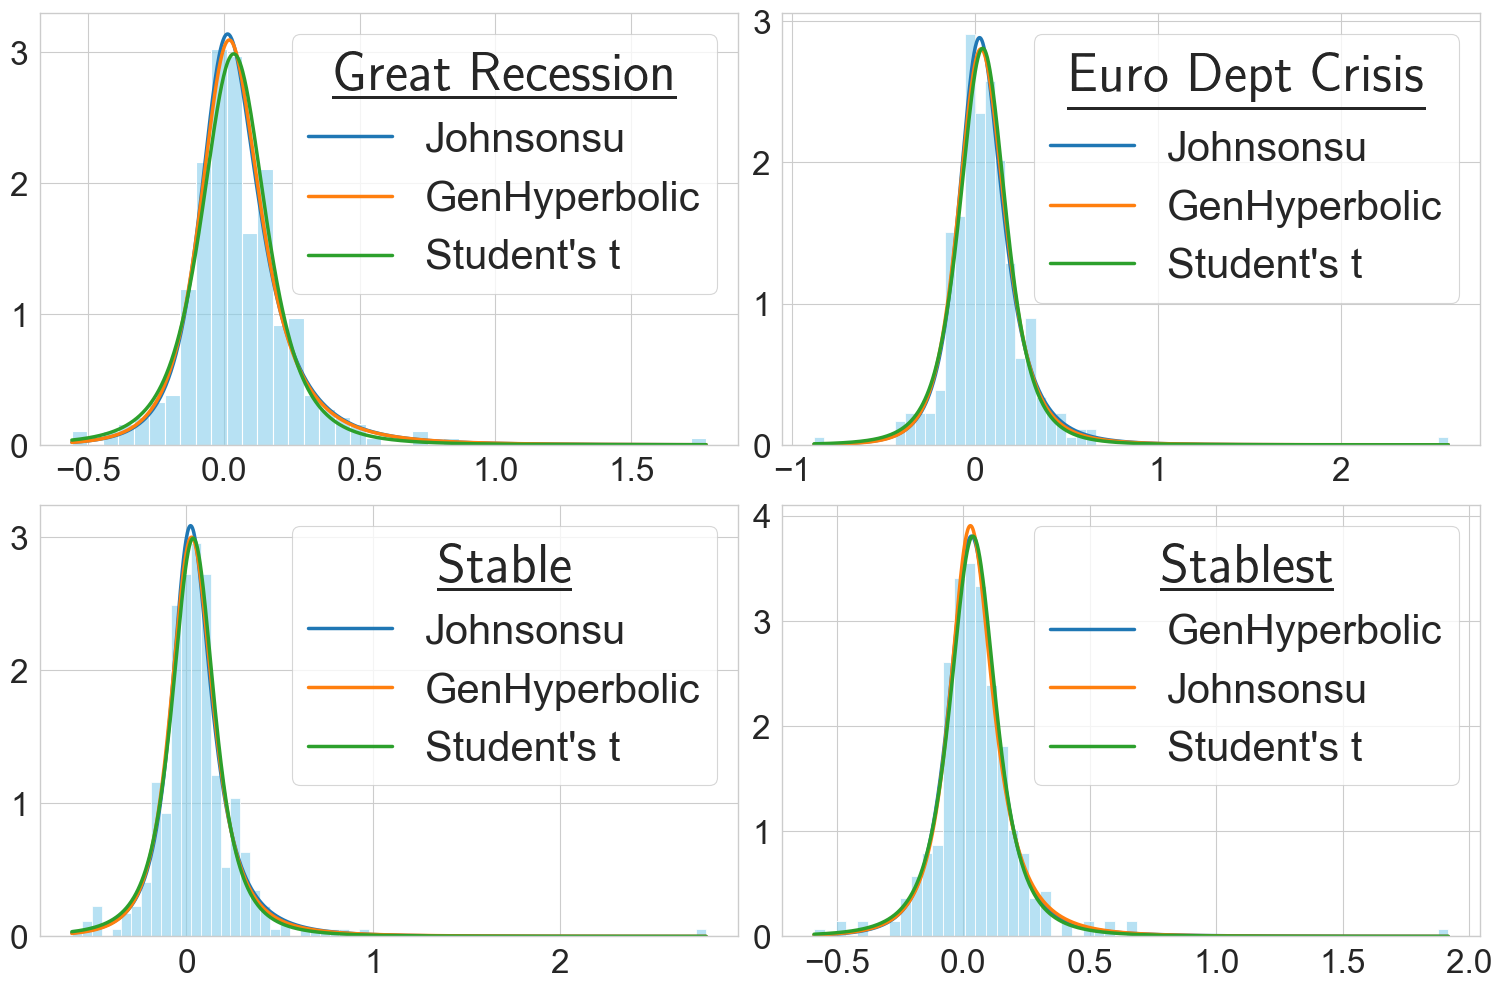

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def fit_and_plot_distributions(key, parameters, label, fig, ax, exclude_negative=False):
    if key == 'J':
        parameter = parameters[np.triu_indices_from(parameters, k=1)]
    else:
        parameter = parameters

    distributions = {
        'Johnsonsu': johnsonsu,
        'Maxwell': maxwell,
        'Student\'s t': t,
        #'Laplace': laplace,
        'Normal': norm,
        'GEV': genextreme,
        'Burr': burr,
        'GenHyperbolic': genhyperbolic,
        'Fisk': fisk,
        'ExponNorm': exponnorm,
        'Alpha': alpha,
        'FoldCauchy': foldcauchy
    }

    positive_only_dists = ['Log-normal', 'Pareto', 'Weibull', 'Gamma']
    ks_results = {}
    sortable_list = []

    for name, dist in distributions.items():
        if exclude_negative and name in positive_only_dists:
            continue

        data_to_fit = parameter if name not in positive_only_dists else parameter[parameter > 0]
        params = dist.fit(data_to_fit)
        ks_stat, ks_pval = kstest(data_to_fit, dist.cdf, params)
        
        if ks_pval > 0.05:
            ks_results[name] = (ks_stat, ks_pval)
            sortable_list.append((ks_pval, name, dist))

    sortable_list.sort(reverse=True, key=lambda x: x[0])
    distributions_to_fit = {name: dist for _, name, dist in sortable_list}

    plot_distributions(key, parameter, distributions_to_fit, label, fig, ax)

def plot_distributions(key, parameter, distributions, label, fig, ax):
    sns.set_style('whitegrid')
    sns.histplot(parameter, kde=False, color='skyblue', stat="density", alpha=0.6, ax=ax)
    x_values = np.linspace(min(parameter), max(parameter), 1000)
    top_three_distributions = list(distributions.items())[:3]
    
    for name, dist in top_three_distributions:
        params = dist.fit(parameter)
        ax.plot(x_values, dist.pdf(x_values, *params), linewidth=2.5, label=name)

    xlabel = '$\mathit{J_{ij}}$' if key == 'J' else '$\mathit{h_{i}}$'
    # ax.set_xlabel(rf'{xlabel}', fontsize=30)
    ax.set_xlabel('', fontsize=30)
    ax.set_ylabel('', fontsize=18)

    # Custom legend handling
    handles, labels = ax.get_legend_handles_labels()
    legend_title = f'{label}'
    custom_legend = ax.legend(handles, labels, title=legend_title, title_fontsize=40, fontsize=30)
    
    # Underline the legend title using text properties
    title_text = custom_legend.get_title()
    title_text.set_usetex(True)  # Enable LaTeX rendering
    title_text.set_text(r'\underline{' + legend_title + '}')  # Apply underline with LaTeX command

    ax.tick_params(axis='both', which='major', labelsize=24)

# File paths for the datasets with labels
dates_labels = [
    ('2008-09-17', '2009-09-15', "Great Recession"),
    ('2011-05-06', '2012-05-03', "Euro Dept Crisis"),
    ('2017-05-31', '2018-05-29', "Stable"),
    ('2019-03-08', '2020-03-06', "Stablest")
]

# fig, axs = plt.subplots(len(dates_labels), 1, figsize=(8, 20))
# Create figure and axes objects
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjusted for 2x2 grid

# Flatten the array of axes, to iterate easily
axs = axs.flatten()

for idx, (start_date, end_date, label) in enumerate(dates_labels):
    ising_optimiser = IsingOptimiser(data_matrix, start_date, end_date)
    _, J, h = ising_optimiser.train(100)
    fit_and_plot_distributions('J', J, label, fig, axs[idx])

fig.tight_layout()
figure_name = f"Images/Distributions/Js.svg"
plt.savefig(figure_name, format="svg", bbox_inches='tight')
plt.show()


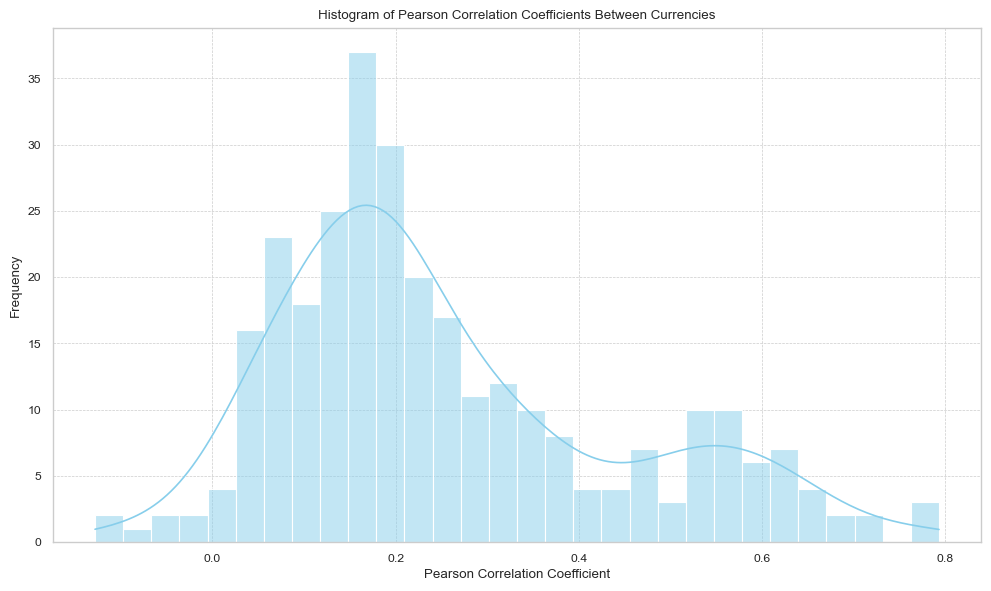

In [34]:
import pandas as pd
import numpy as np

log_returns_df = pd.read_csv('Results/log_returns.csv').drop(columns=['Date'])

# Calculate the Pearson correlation coefficients
correlation_matrix = log_returns_df.corr()

# Flatten the correlation matrix to a 1D array of correlation coefficients, excluding self-correlations (diagonal)
corr_coefficients = correlation_matrix.values[np.tril_indices_from(correlation_matrix, k=-1)]

# Plot the histogram of correlation coefficients
plt.figure(figsize=(10, 6))
sns.histplot(corr_coefficients, bins=30, kde=True, color='skyblue')
plt.title('Histogram of Pearson Correlation Coefficients Between Currencies')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

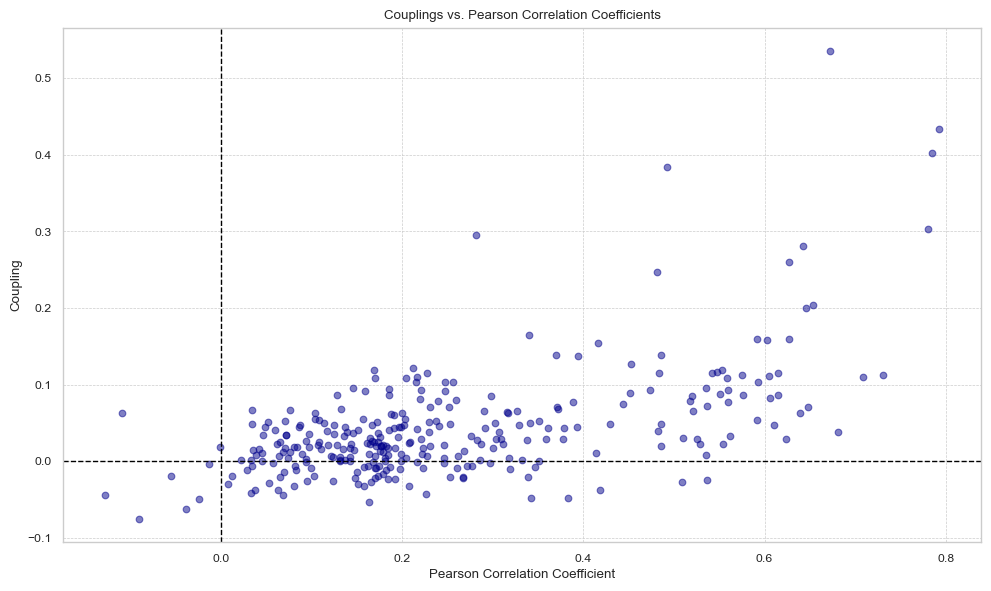

In [35]:
J_df = pd.read_csv('Results/J.csv').values
J = J_df[np.tril_indices_from(J_df, k=-1)]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(corr_coefficients, J, color='darkblue', alpha=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title('Couplings vs. Pearson Correlation Coefficients')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Coupling')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()